In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [2]:
all_seasons = []

for season in range(2019, 2024):
    
    percentages_url = f"https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId={season}{season+1}"
    percentages_resp = requests.get(percentages_url)
    percentages_json = percentages_resp.json()

    df_percentages = DataFrame(percentages_json['data'])
    all_seasons.append(df_percentages)
    print(f"Successfully fetched data for season {season}-{season+1}")

df_combined_percentages = pd.concat(all_seasons, ignore_index=True)
df_combined_percentages = df_combined_percentages.groupby('playerId').agg({
        'playerId': 'first',
        'positionCode': 'first',
        'gamesPlayed': 'sum',
        'skaterFullName': 'first',
        'zoneStartPct5v5': 'mean',
        'shootingPct5v5': 'mean',
        'usatPrecentageClose': 'mean',
        'usatPercentageTied': 'mean',
        'satPercentageClose': 'mean',
        'satPercentageTied': 'mean',
    }).reset_index(drop = True)
    
print(df_combined_percentages)

Successfully fetched data for season 2019-2020
Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId positionCode  gamesPlayed     skaterFullName  zoneStartPct5v5  \
0      8465009            D          213        Zdeno Chara         0.414000   
1      8466138            C          156       Joe Thornton         0.610333   
2      8466139            C          126    Patrick Marleau         0.524333   
3      8468493            D           64        Ron Hainsey         0.486000   
4      8468508            R           27    Justin Williams         0.472000   
...        ...          ...          ...                ...              ...   
1447   8484314            L           20       Jiri Smejkal         0.487000   
1448   8484321            D            4  Nikolas Matinpalo         0.461000   
1449   8484325            C           19    W

In [3]:
df_combined_percentages = df_combined_percentages.loc[(df_combined_percentages['positionCode'] != 'D') & (df_combined_percentages['gamesPlayed'] >= 80)]
df_combined_percentages = df_combined_percentages.reset_index()
df_combined_percentages = df_combined_percentages.fillna(0)
df_combined_percentages.rename(columns = {'usatPrecentageClose': 'usatPercentageClose'}, inplace = True)

In [4]:
all_seasons = []

for season in range(2019, 2024):
    
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}"
    summary_resp = requests.get(summary_url)
    summary_json =  summary_resp.json()

    df_summary = DataFrame(summary_json['data'])
    all_seasons.append(df_summary)
    print(f"Successfully fetched data for season {season}-{season+1}")

df_combined_summary = pd.concat(all_seasons, ignore_index=True)
df_combined_summary = df_combined_summary.groupby('playerId').agg({
        'playerId': 'first',
        'positionCode': 'first',
        'gamesPlayed': 'sum',
        'evGoals': 'sum',
        'goals': 'sum',
        'skaterFullName': 'first',
        'otGoals': 'sum',
        'gameWinningGoals': 'sum',
        'shGoals': 'sum'
    }).reset_index(drop = True)
    
print(df_combined_summary)

Successfully fetched data for season 2019-2020
Successfully fetched data for season 2020-2021
Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId positionCode  gamesPlayed  evGoals  goals     skaterFullName  \
0      8465009            D          213        9      9        Zdeno Chara   
1      8466138            C          156       11     18       Joe Thornton   
2      8466139            C          126       12     15    Patrick Marleau   
3      8468493            D           64        1      1        Ron Hainsey   
4      8468508            R           27        7      9    Justin Williams   
...        ...          ...          ...      ...    ...                ...   
1447   8484314            L           20        1      1       Jiri Smejkal   
1448   8484321            D            4        0      0  Nikolas Matinpalo   
1449   8484325            C           19        1     

In [5]:
df_combined_summary = df_combined_summary.loc[(df_combined_summary['positionCode'] != 'D') & (df_combined_summary['gamesPlayed'] >= 68) & (df_combined_summary['goals'] >= 27)]
df_combined_summary['clutchgoalsRatio'] = (3 * df_combined_summary['otGoals'] + 6 * df_combined_summary['gameWinningGoals'] + df_combined_summary['shGoals'] ) / df_combined_summary['gamesPlayed'] * 82
df_combined_summary = df_combined_summary.reset_index(drop = True)
df_combined_summary = df_combined_summary.fillna(0)

In [6]:
df_players_merged = df_combined_percentages.merge(df_combined_summary, on = 'playerId', how = 'right', suffixes=('', '_x'))
df_players_merged.drop(columns = ['positionCode_x', 'gamesPlayed_x', 'positionCode_x', 'skaterFullName_x'], axis=1, inplace=True)
df_players_merged

,index,playerId,positionCode,gamesPlayed,skaterFullName,zoneStartPct5v5,shootingPct5v5,usatPercentageClose,usatPercentageTied,satPercentageClose,satPercentageTied,evGoals,goals,otGoals,gameWinningGoals,shGoals,clutchgoalsRatio
0,7,8469455,C,200,Jason Spezza,0.544000,0.091000,0.512667,0.523000,0.528667,0.529667,28,34,0,3,0,7.380000
1,18,8470595,C,237,Eric Staal,0.499500,0.073250,0.502750,0.504250,0.502500,0.516750,34,43,2,8,3,19.721519
2,21,8470604,C,354,Jeff Carter,0.381000,0.065833,0.494500,0.495667,0.497167,0.498833,64,85,3,17,3,26.406780
3,22,8470606,R,186,Dustin Brown,0.504000,0.074333,0.510667,0.525000,0.506333,0.514333,32,43,0,2,0,5.290323
4,24,8470610,L,333,Zach Parise,0.467800,0.083400,0.490200,0.482000,0.487800,0.480000,55,77,1,15,5,24.132132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1352,8482665,C,181,Matty Beniers,0.568667,0.096000,0.485000,0.498000,0.485667,0.494333,33,45,1,5,0,14.950276
369,1361,8482705,C,220,Cole Sillinger,0.560000,0.076333,0.456333,0.465667,0.456333,0.462000,29,32,0,4,0,8.945455
370,1369,8482740,C,202,Wyatt Johnston,0.517500,0.091000,0.515500,0.519500,0.520000,0.531000,58,70,1,10,4,27.198020
371,1371,8482745,C,153,Mason McTavish,0.487333,0.093667,0.447000,0.431000,0.437333,0.426667,26,38,1,5,1,18.222222


In [7]:
df_players_merged[['clutchgoalsRatio']].describe(percentiles=[0.08, 0.75, 0.8,0.85, 0.9])

,clutchgoalsRatio
count,373.000000
mean,20.173616
std,12.085379
min,1.093333
8%,5.616301
50%,17.528256
75%,26.980645
80%,29.436866
85%,32.346484
90%,36.567932


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


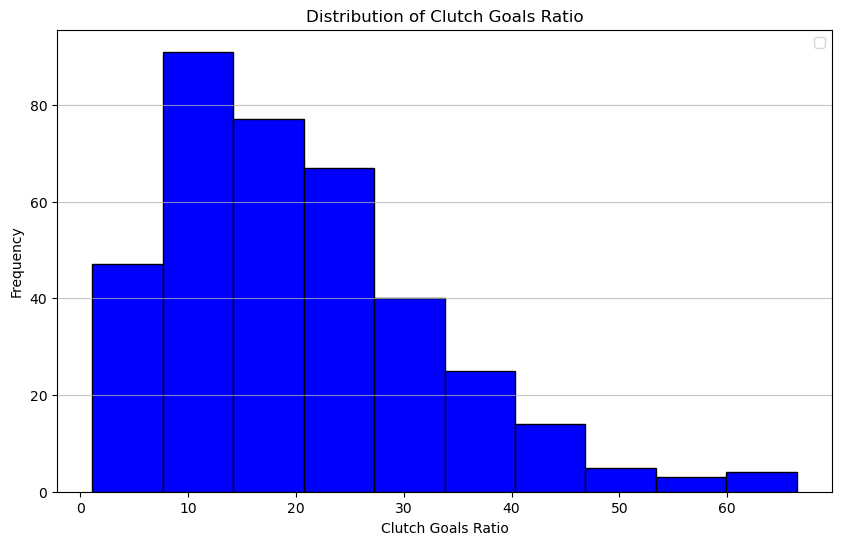

In [15]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_players_merged['clutchgoalsRatio'], color='blue', edgecolor='black')
plt.title('Distribution of Clutch Goals Ratio')
plt.xlabel('Clutch Goals Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

In [17]:
low = df_players_merged['clutchgoalsRatio'].quantile(0.25)
average = df_players_merged['clutchgoalsRatio'].quantile(0.35)
high = df_players_merged['clutchgoalsRatio'].quantile(0.75)
elite = df_players_merged['clutchgoalsRatio'].quantile(0.9)


def binary_clutchness(row):
    clutchness = row['clutchgoalsRatio']
    if clutchness >= 35:
        return 2
    elif 15 <= clutchness < 35:
        return 1
    else:
        return 0

    
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [19]:
df_players_merged['clutchgoalsRatio'] = pd.to_numeric(df_players_merged['clutchgoalsRatio'], errors='coerce')

In [21]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
1    178
0    152
2     43
Name: count, dtype: int64

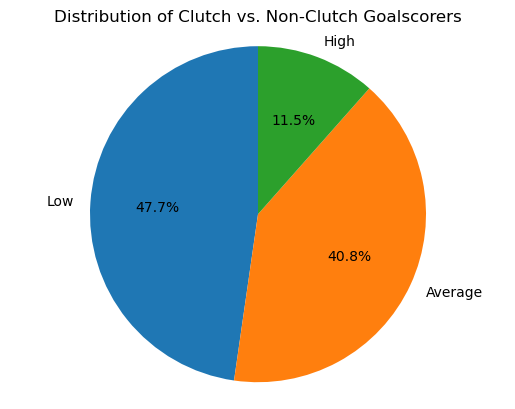

In [23]:
key = [ 'Low',  'Average',  'High']

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [25]:
df_players_merged.loc[df_players_merged['clutch_performance'] == 2]

,index,playerId,positionCode,gamesPlayed,skaterFullName,zoneStartPct5v5,shootingPct5v5,usatPercentageClose,usatPercentageTied,satPercentageClose,satPercentageTied,evGoals,goals,otGoals,gameWinningGoals,shGoals,clutchgoalsRatio,clutch_performance
6,30,8470638,C,300,Patrice Bergeron,0.609000,0.087000,0.625500,0.624500,0.618250,0.618500,72,116,3,22,6,40.180000,2
14,53,8471675,C,345,Sidney Crosby,0.637200,0.087400,0.532600,0.531200,0.540400,0.537800,113,151,6,30,1,47.298551,2
20,77,8473419,L,397,Brad Marchand,0.579000,0.093200,0.580600,0.581600,0.575400,0.578200,109,165,6,33,11,46.886650,2
43,129,8474157,L,243,Max Pacioretty,0.546800,0.085000,0.562000,0.541800,0.543600,0.526200,69,92,5,19,0,43.530864,2
46,142,8474564,C,394,Steven Stamkos,0.552800,0.109400,0.497200,0.504200,0.505600,0.509200,111,189,5,33,0,44.329949,2
58,190,8475151,C,352,Kyle Palmieri,0.516833,0.089167,0.479000,0.488000,0.479333,0.484167,75,106,3,24,1,35.875000,2
62,195,8475166,C,389,John Tavares,0.546600,0.085200,0.525600,0.528400,0.528600,0.532200,94,147,6,25,0,35.413882,2
68,207,8475184,L,401,Chris Kreider,0.499000,0.097000,0.505600,0.495200,0.496000,0.492600,102,196,2,36,12,47.850374,2
84,263,8475754,C,412,Brock Nelson,0.523000,0.099800,0.472000,0.464800,0.476400,0.468800,131,171,5,29,1,37.815534,2
102,304,8475913,R,324,Mark Stone,0.546200,0.099000,0.525400,0.520200,0.515600,0.512400,74,110,2,22,7,36.697531,2


In [27]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import math

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'goals']
y_var = 'clutch_performance'

df_players_merged['closePerformance'] = (df_players_merged['usatPercentageClose'] + df_players_merged['satPercentageClose']) / 2
df_players_merged['tiedPerformance'] = (df_players_merged['usatPercentageTied'] + df_players_merged['satPercentageTied']) / 2


df_players_merged['usatPerformance'] = (df_players_merged['usatPercentageClose'] + df_players_merged['usatPercentageTied']) / 2
df_players_merged['satPerformance'] = (df_players_merged['satPercentageTied'] + df_players_merged['satPercentageClose']) / 2

df_players_merged['weighted_close_performance'] = (0.6 * df_players_merged['usatPercentageClose'] + 0.4 * df_players_merged['satPercentageClose'])
df_players_merged['weighted_tied_performance'] = (0.6 * df_players_merged['usatPercentageTied'] + 0.4 * df_players_merged['satPercentageTied'])

df_players_merged['overall'] = (df_players_merged['usatPercentageClose'] + df_players_merged['satPercentageClose'] 
                                + df_players_merged['usatPercentageTied'] + df_players_merged['satPercentageTied']) / 4
    

'''x_var.extend([
        'closePerformance',
        'tiedPerformance',
        'usatPerformance',
        'satPerformance',        
        'weighted_close_performance',
        'weighted_tied_performance',
        'overall',
    ])'''


X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify =y)
le = LabelEncoder()
train_y = le.fit_transform(train_y)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

scores = cross_validate(xgb_model, X, y, cv=skf, scoring=scoring)

df = pd.DataFrame.from_dict(scores)

df.mean()

fit_time                0.292764
score_time              0.032522
test_accuracy           0.707676
test_precision_macro    0.706934
test_recall_macro       0.673066
test_f1_macro           0.680617
dtype: float64

In [30]:
print("Unique classes in train_y:", np.unique(train_y))


Unique classes in train_y: [0 1 2]


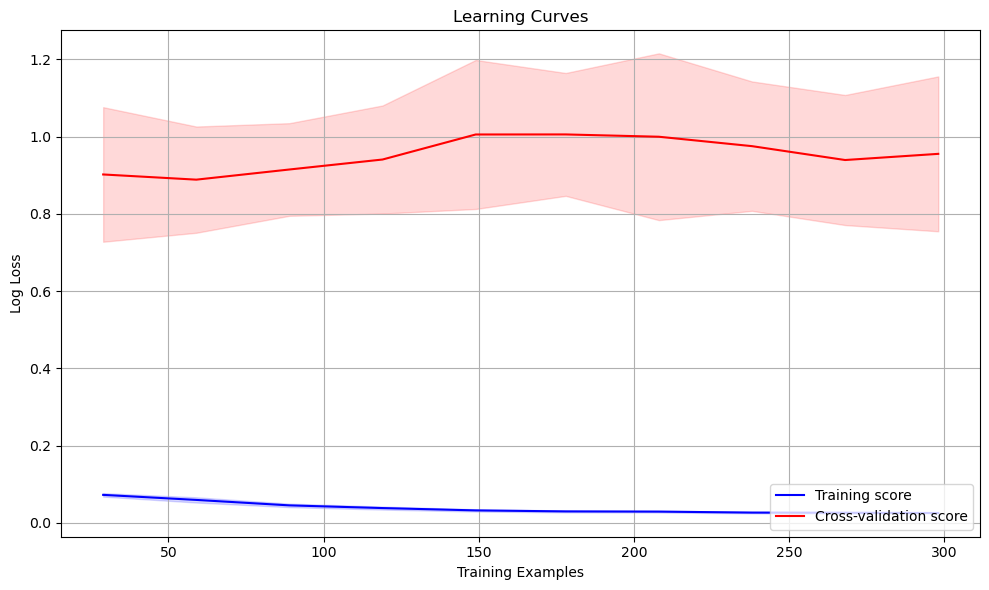

In [33]:
from sklearn.model_selection import learning_curve
cv = StratifiedKFold(n_splits=5)

train_sizes = np.linspace(0.1, 1.0, 10)
    
# Calculate learning curves
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

# Calculate mean and std
train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

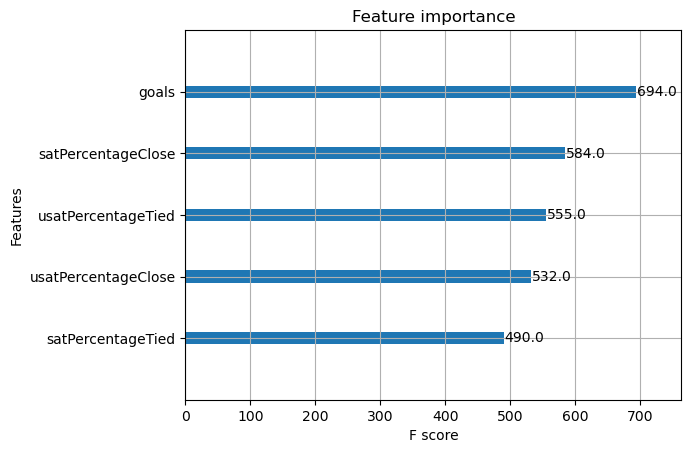

In [34]:
plot_importance(xgb_model)
plt.show()

In [37]:
print(x_var)

['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'goals']


In [42]:
features_to_remove = ['satPerformance', 'tiedPerformance']

for feature in features_to_remove:
    x_var.remove(feature)

ValueError: list.remove(x): x not in list

In [ ]:
print(x_var)

In [ ]:
pip install imbalanced-learn

In [43]:
print(train_y.value_counts())


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [39]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

X_adjusted = df_players_merged[x_var]
y_var = 'clutch_performance'
y = df_players_merged[y_var]


train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.3, 
    stratify=y 
)



class_labels = df_players_merged['clutch_performance'].unique()
class_weights = compute_class_weight('balanced', classes=class_labels, y=df_players_merged['clutch_performance'])
weight_dict = dict(zip(class_labels, class_weights))

weight_dict[2] *= 2


# Initialize and train the XGBoost model
xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_adjusted.fit(train_x, train_y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [41]:
print(X_adjusted)

     usatPercentageClose  usatPercentageTied  satPercentageClose  \
0               0.512667            0.523000            0.528667   
1               0.502750            0.504250            0.502500   
2               0.494500            0.495667            0.497167   
3               0.510667            0.525000            0.506333   
4               0.490200            0.482000            0.487800   
..                   ...                 ...                 ...   
368             0.485000            0.498000            0.485667   
369             0.456333            0.465667            0.456333   
370             0.515500            0.519500            0.520000   
371             0.447000            0.431000            0.437333   
372             0.509500            0.498000            0.527500   

     satPercentageTied  goals  
0             0.529667     34  
1             0.516750     43  
2             0.498833     85  
3             0.514333     43  
4             0.480000 

In [43]:
print(weight_dict)

{0: 0.8179824561403509, 1: 0.6985018726591761, 2: 5.782945736434108}


In [45]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical


'''param_grid = {
    'max_depth': Integer(2, 4),  # Integer values between 2 and 4
    'subsample': Categorical([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),  # Categorical options
    'n_estimators': Integer(150, 200),  # Integer values between 150 and 200
    'min_child_weight': Integer(3, 4),  # Integer values between 3 and 4
    'learning_rate': Real(0.01, 0.03),  # Float values between 0.01 and 0.03
    'reg_alpha': Real(1, 1.5),  # Float values between 1 and 1.5
    'reg_lambda': Real(1, 1.3),  # Float values between 1 and 1.3
    'colsample_bytree': Categorical([0.5, 0.6, 0.7, 0.8]),  # Categorical options
}'''

param_grid = {
    'max_depth': Integer(2,6),  # Reduced from 5 to limit complexity
    'min_child_weight': Integer(2,3),  # Increased to prevent overfitting
    'n_estimators': Integer(150, 275),  # Narrowed based on your curves
    'learning_rate': Real(0.03, 0.055),  # Slightly lower than current ~0.14
    'reg_alpha': Real(0.75, 1.8),  # Reduced from current ~1.87
    'reg_lambda': Real(0.75, 1.8),  # Reduced from current ~2.92
    'subsample': Real(0.7, 1),  # Slightly higher than current ~0.74
    'colsample_bytree': Real(0.7, 1)  # Higher than current ~0.64
}


def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}



In [47]:
print(train_x.shape, train_y.shape)  # Should match
print(test_x.shape, test_y.shape)     # Should match


(261, 5) (261,)
(112, 5) (112,)


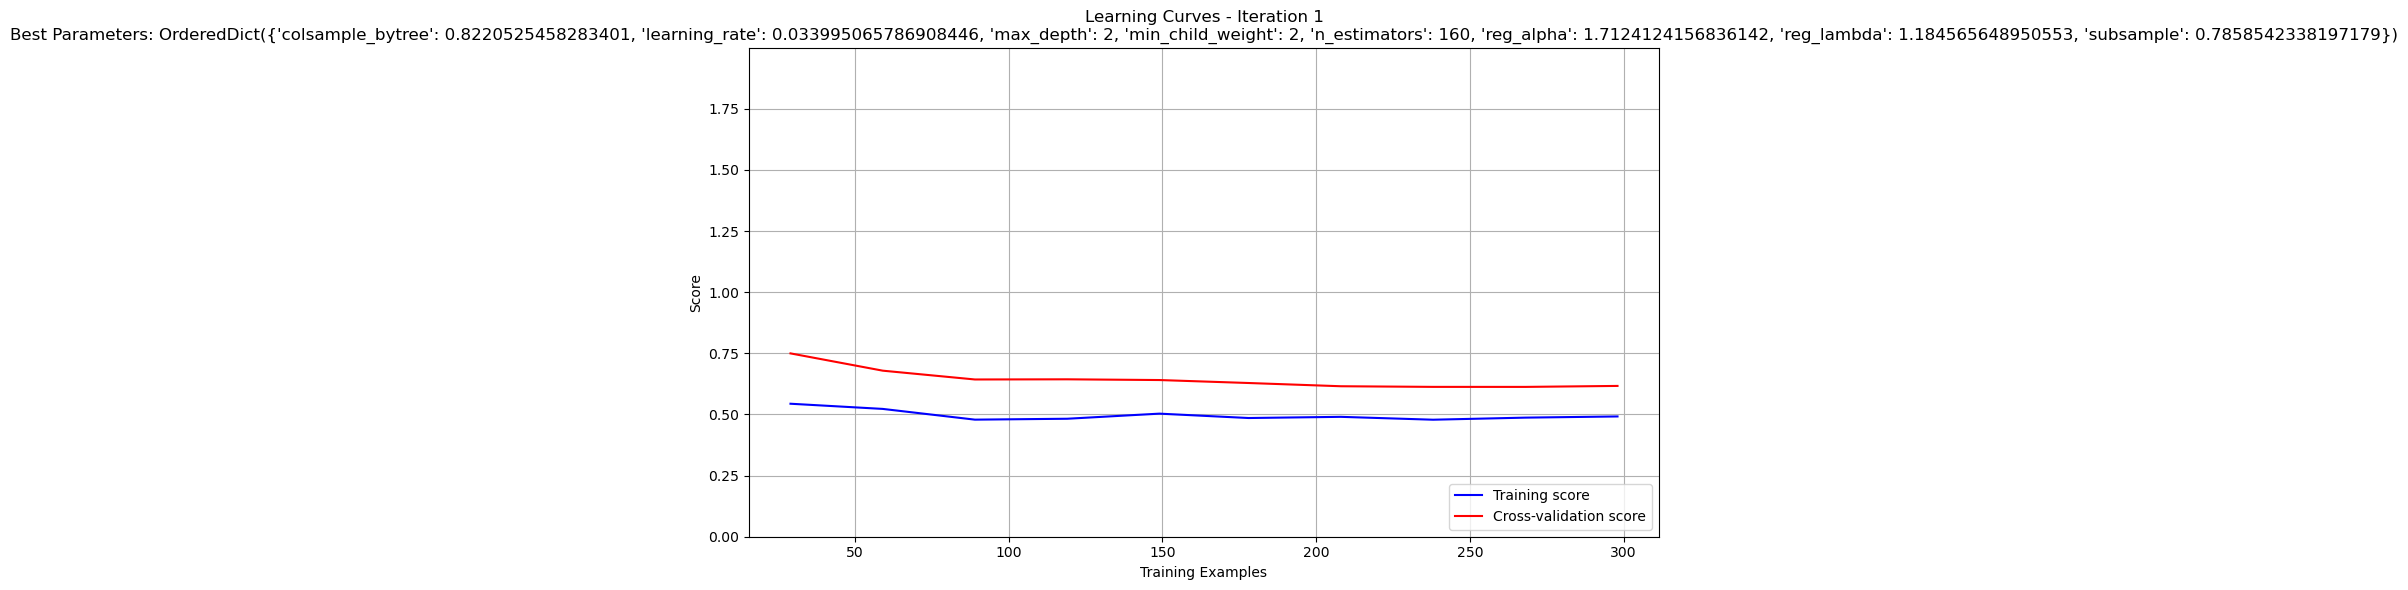

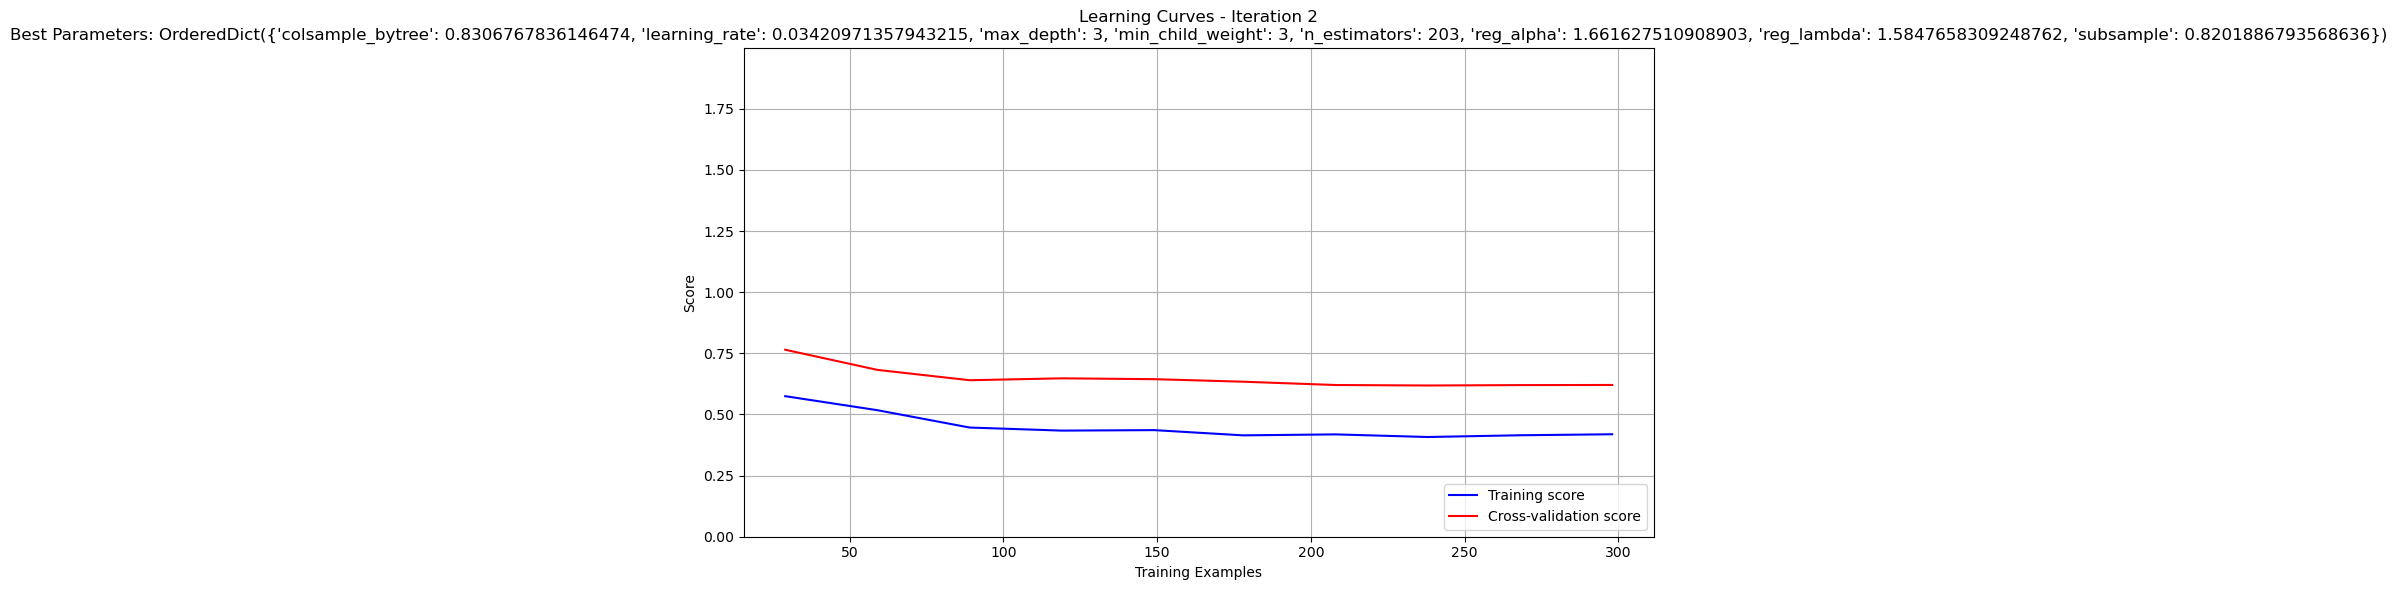

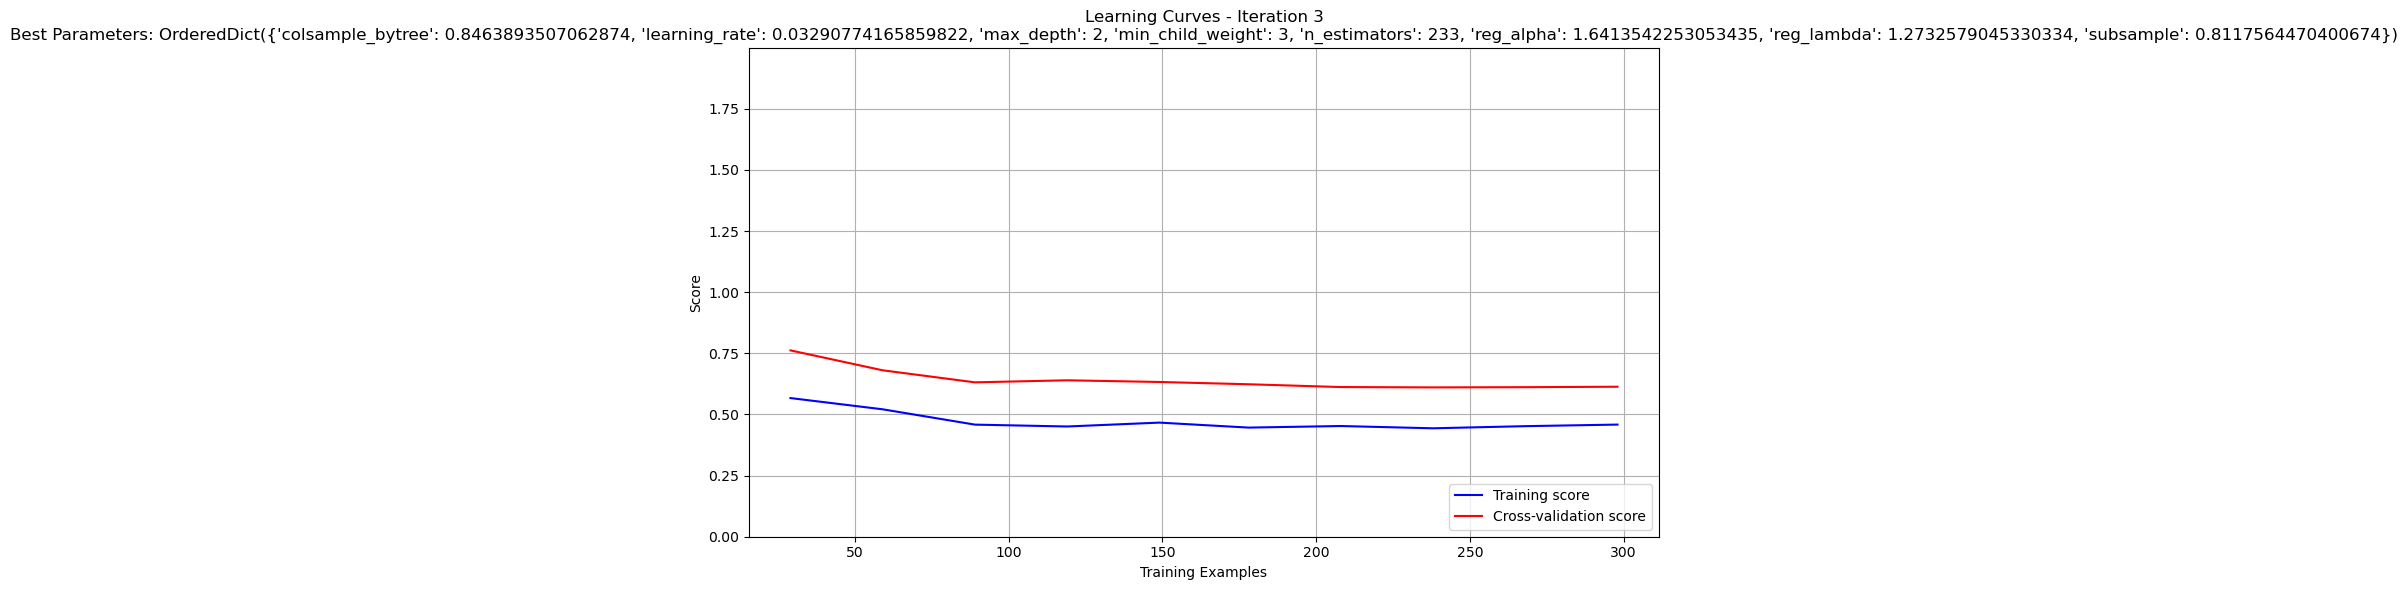

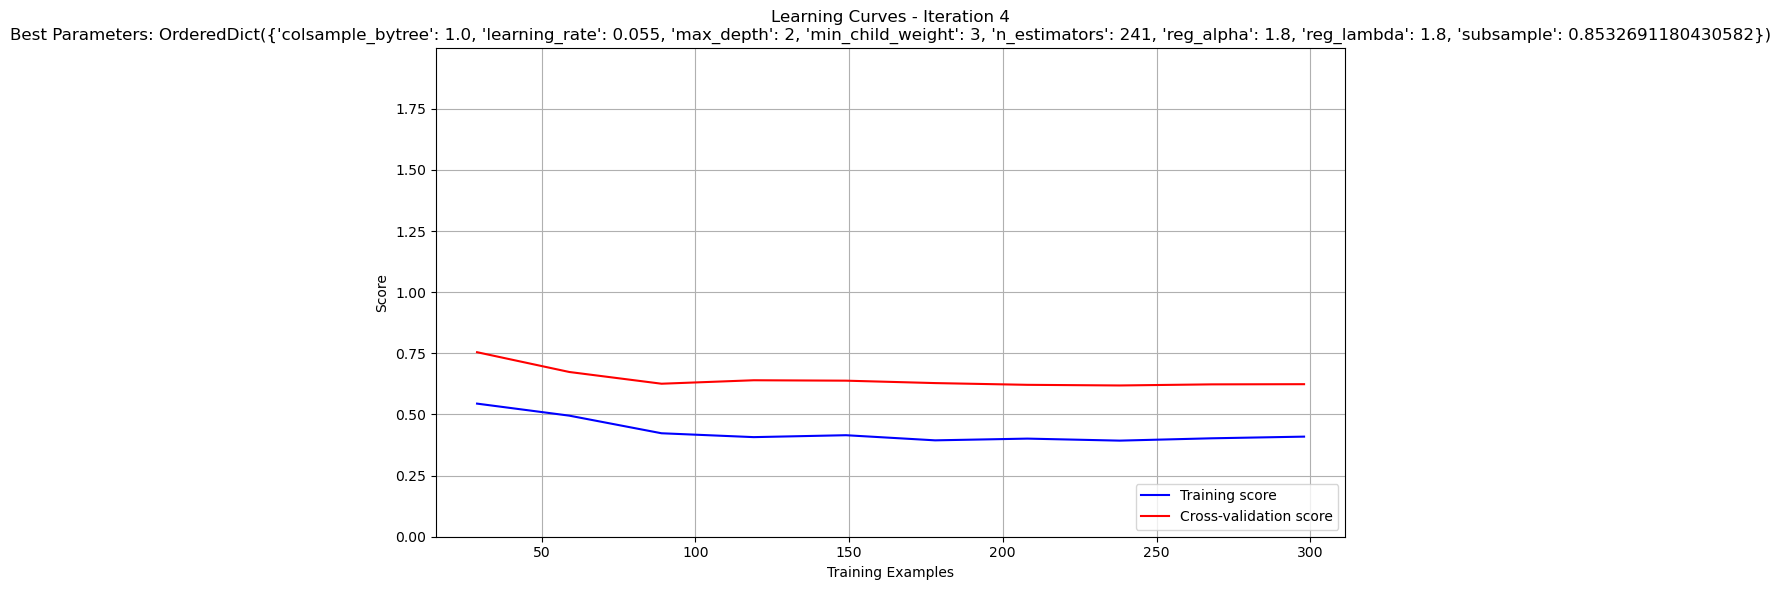

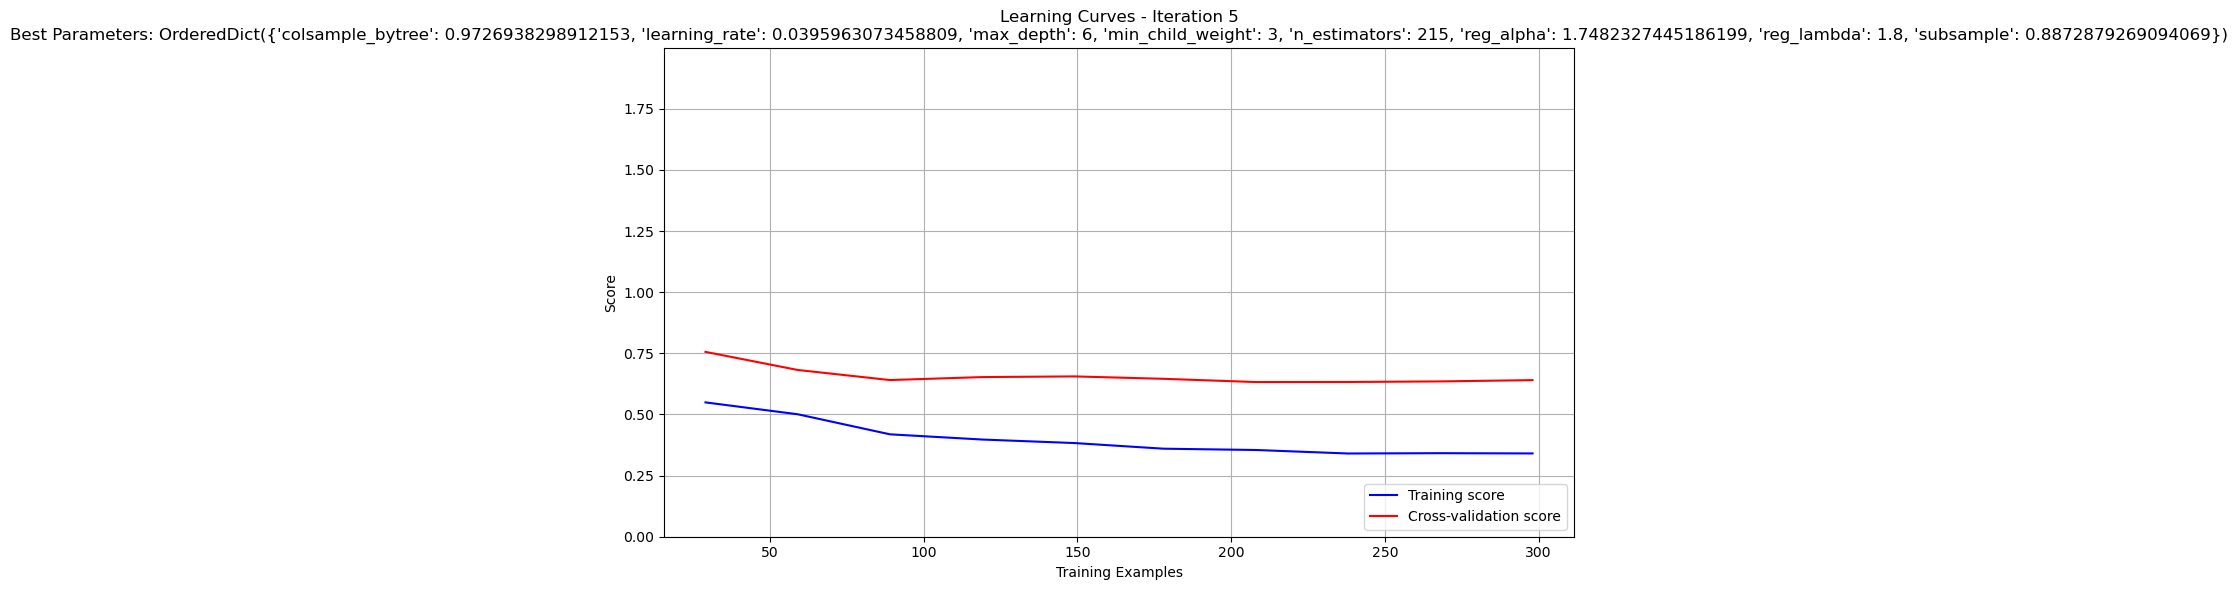

Average Accuracy: 0.7464285714285714
Average Precision: 0.7879807089841195
Average Recall: 0.7113754443532951
Average F1 Score: 0.7393490195315878
Averaged Hyperparameters:
colsample_bytree      0.894363
learning_rate         0.039142
max_depth             3.000000
min_child_weight      2.800000
n_estimators        210.400000
reg_alpha             1.712725
reg_lambda            1.528518
subsample             0.831671
dtype: float64


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=5)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):
    """macro
    Generate and plot learning curves for a given estimator
    """
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 2)
    plt.yticks([i * 0.25 for i in range(8)])  # Set ticks from 0 to 1 with a step of 0.1
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


# Hyperparameter tuning
for _ in range(5):
    rs = np.random.randint(1, 1000)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall_macro', 'f1_macro', 'balanced_accuracy'], refit='f1_macro', random_state=rs, n_jobs = -1, fit_params = fit_params)


    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_

    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, X, y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  # Probabilities for all classes

    # Metrics
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average='macro', zero_division=0)
    recall = recall_score(test_y, y_pred, average='macro')
    f1 = f1_score(test_y, y_pred, average='macro')

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

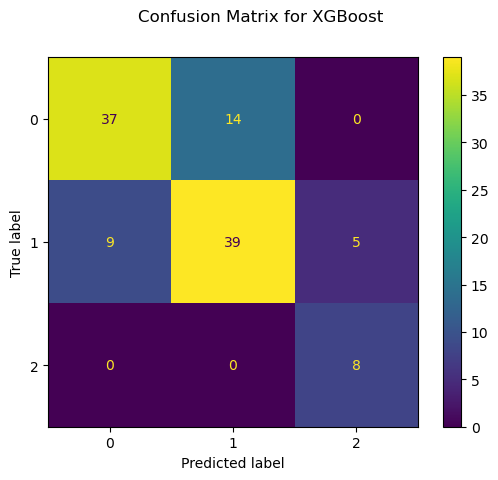

In [55]:
conf_matrix = confusion_matrix(y_pred, test_y)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [269]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_x[X_adjusted])

shap.summary_plot(shap_values, train_x[X_adjusted])

ValueError: Boolean array expected for the condition, not float64

In [165]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    xgb_best_model, 
    test_x,    # Use test set features 
    test_y,    # Use test set labels
    n_permutations=1000,
    scoring='accuracy',
    n_jobs=-1
)

print(f"Score: {score:.3f}")
print(f"P-value: {pvalue:.3f}")
print(f"Permutation scores mean: {permutation_scores.mean():.3f}")
print(f"Permutation scores std: {permutation_scores.std():.3f}")

C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Score: 0.444
P-value: 0.045
Permutation scores mean: 0.372
Permutation scores std: 0.041


In [166]:
pvalue

0.04495504495504495

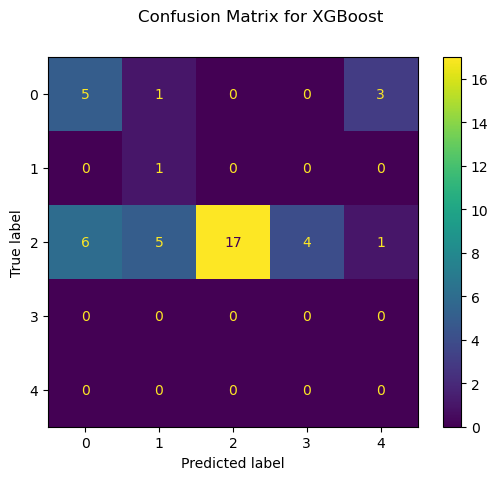

In [167]:
conf_matrix = confusion_matrix(y_pred, test_y)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [20]:
'''import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
}

metrics = {name: {'precision': [], 'recall': [], 'auc_pr': [], 'f1_score': []} for model_name in models}
def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    skf = StratifiedKFold(n_splits = 5)

    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold

        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
            

        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    return {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }


for model_name, model in models.items():
    results = evaluate_model(model, x, y)
    for metric in metrics[model_name]:
        metrics[model_name][metric] = results[metric]

data_for_tests = {
    'precision': [metrics[name]['precision'] for name in models],
    'recall': [metrics[name]['recall'] for name in models],
    'auc_pr': [metrics[name]['auc_pr'] for name in models],
    'f1_score': [metrics[name]['f1_score'] for name in models],
}

for metric, data in data_for_tests.items():
    stat, p = friedmanchisquare(*data)
    print(f'Friedman test for {metric.capitalize()}: statistic={stat}, p-value={p}')''

SyntaxError: incomplete input (1777348547.py, line 1)

In [ ]:
'''for model_name in metrics.keys():
    print(f"{model_name} recall: {metrics[model_name]['recall']}")'''
    

In [ ]:
'''import pandas as pd

# Extract precision scores
precision_data = []

for model_name, metrics_values in metrics.items():
    precision_scores = metrics_values['recall']
    
    for fold_index, score in enumerate(precision_scores):
        precision_data.append({
            'Model': model_name,
            'Fold': fold_index + 1,
            'Precision': score
        })

precision_df = pd.DataFrame(precision_data)

knn_precision = precision_df.loc[precision_df['Model'] == 'KNN', 'Precision'].values
random_forest_precision = precision_df.loc[precision_df['Model'] == 'Random Forest', 'Precision'].values
xgboost_forest_precision = precision_df.loc[precision_df['Model'] == 'XGBoost', 'Precision'].values

res = friedmanchisquare(knn_precision, random_forest_precision, xgboost_forest_precision)
print(res.statistic)
print(res.pvalue)

precision_df['Rank'] = precision_df.groupby('Fold')['Precision'].rank(ascending=False)

rank_sum = precision_df.groupby('Model')['Rank'].sum().reset_index()
rank_sum.columns = ['Model', 'Rank_Sum']
rank_sum['Sum Squared'] = rank_sum['Rank_Sum'] ** 2

chi_square = 12 / (10 * 3 * (3 + 1)) * rank_sum['Sum Squared'].sum() - 3 * 10 * (3 + 1)

print(chi_square)
'''

C:\Users\shakj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shakj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Friedman test for Precision: statistic=3.555555555555543, p-value=0.16901331540606715
Friedman test for Recall: statistic=10.866666666666674, p-value=0.0043685098068251505

Metrics Summary for Recall (p < 0.05):
                    mean
KNN            0.052381
Random Forest  0.023810
XGBoost        0.104762
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.346617  0.143528
Random Forest  0.346617       1.000000  0.023123
XGBoost        0.143528       0.023123  1.000000
Friedman test for Auc_pr: statistic=4.133333333333326, p-value=0.12660710278908408
Friedman test for F1_score: statistic=6.864864864864843, p-value=0.03230825746249781

Metrics Summary for F1_score (p < 0.05):
                    mean
KNN            0.072546
Random Forest  0.040251
XGBoost        0.144605
                    KNN  Random Forest   XGBoost
KNN            1.000000       0.622428  0.107564
Random Forest  0.622428       1.000000  0.051650
XGBoost        0.107564       0.051650  1

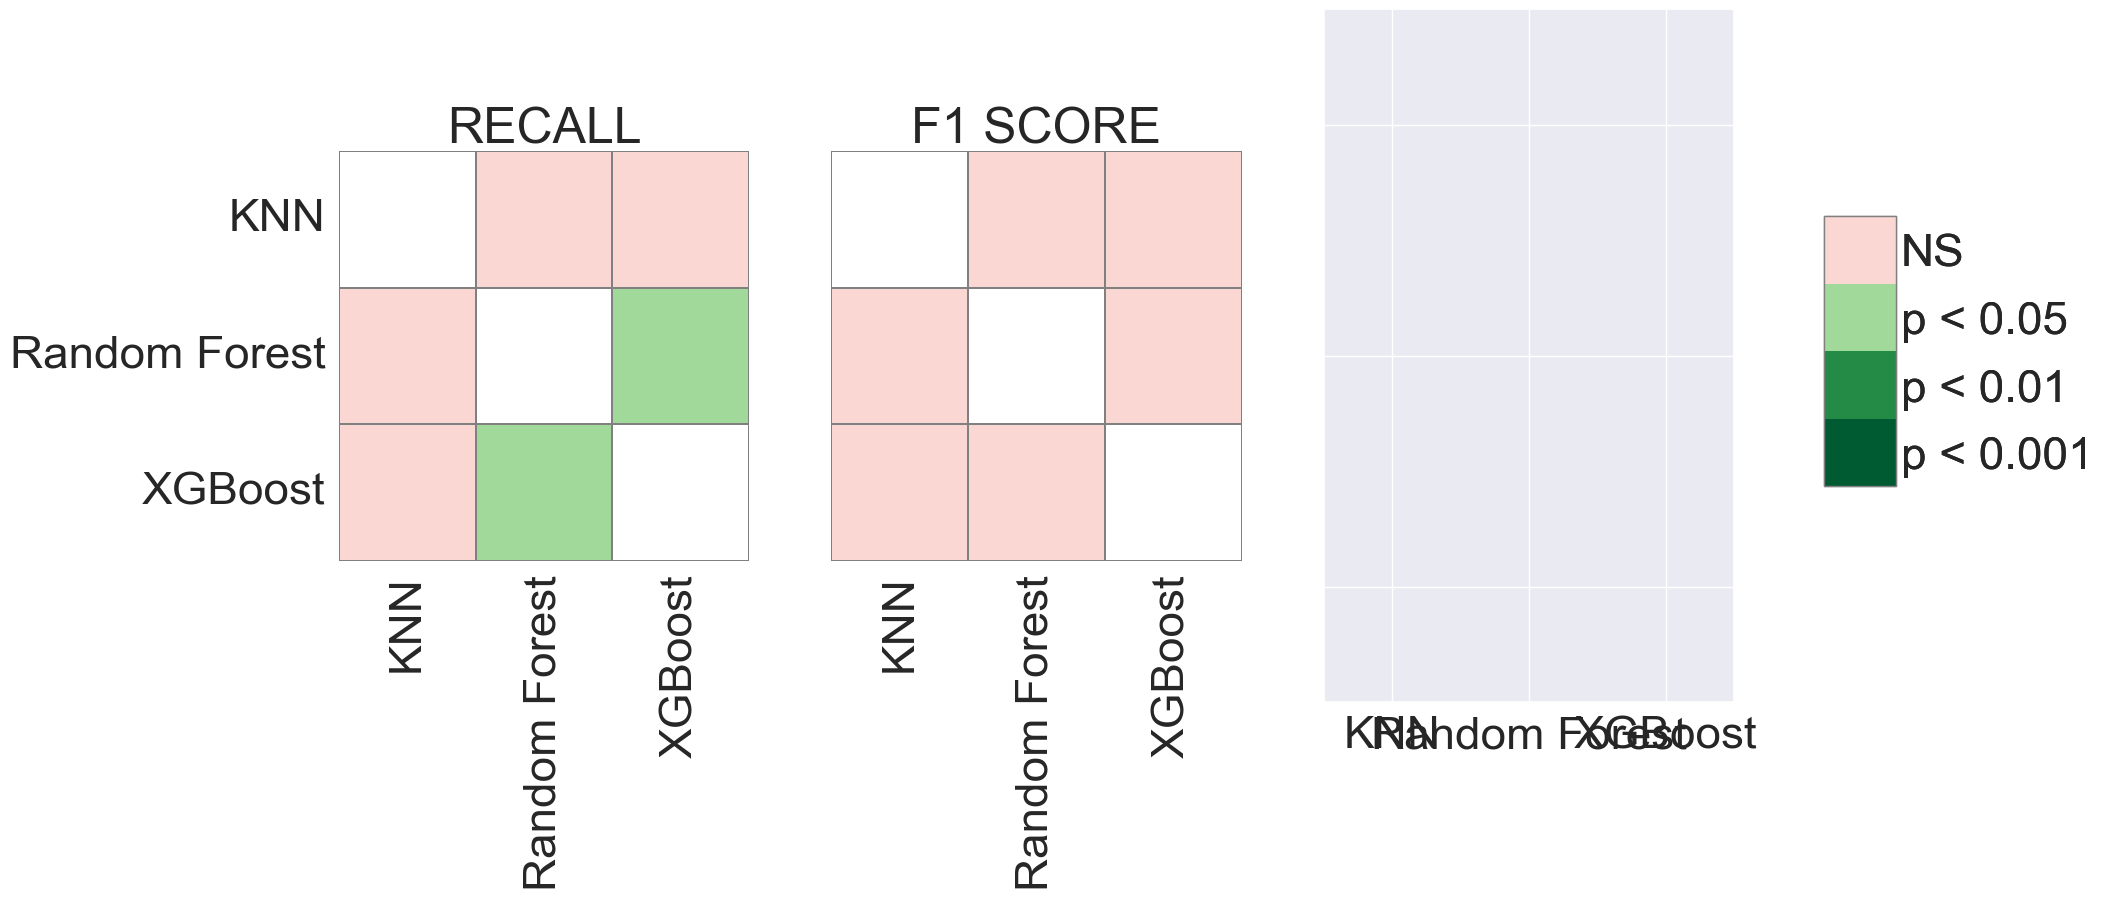

In [62]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp


x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied']
y_var = 'clutch_performance'

x = df_players_merged[x_var]
y = df_players_merged[y_var]

models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators = 300),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss')
    }

metrics_combined =  {'precision': [], 
     'recall': [], 
     'auc_pr': [], 
     'f1_score': []}

skf = StratifiedKFold(n_splits = 15)

def evaluate_model(model, x, y):
    precision_scores = []
    recall_scores = []
    auc_pr_scores = []
    f1_scores = []
    
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(x_train_fold, y_train_fold)
        y_true = y_test_fold
    
        y_pred = model.predict(x_test_fold)
        y_pred_proba = model.predict_proba(x_test_fold)[:, 1]
                
    
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
        auc_pr_scores.append(average_precision_score(y_true, y_pred_proba))
        f1_scores.append(f1_score(y_true, y_pred))

    results = {
        'precision': precision_scores,
        'recall': recall_scores,
        'auc_pr': auc_pr_scores,
        'f1_score': f1_scores
    }
               
    return results
    
for model_name, model in models.items():
    scores = evaluate_model(model, x, y)
    for metric in scores:
        metrics_combined[metric].append(scores[metric])

sns.set(rc={'figure.figsize': (18, 9)}, font_scale = 3)
figure, axes = plt.subplots(1, 3, sharex = True, sharey= True)

i = 0

for name in metrics_combined:
    stat, p = friedmanchisquare(*metrics_combined[name])
    print(f'Friedman test for {name.capitalize()}: statistic={stat}, p-value={p}')
    
    if p < 0.05:
        df_scores = pd.DataFrame(metrics_combined[name]).T
        df_scores.columns = models.keys() 

        metrics_summary = df_scores.agg(['mean']).T
        print(f'\nMetrics Summary for {name.capitalize()} (p < 0.05):\n', metrics_summary)

        
        df_long = df_scores.melt(var_name='Model', value_name='Score')
        
        df = sp.posthoc_conover(df_long, group_col='Model', val_col='Score', p_adjust='holm')
        print(df)

        similarity_matrix = pd.DataFrame(df, index = models.keys())

        heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',  'square': True}

        sub_ax, sub_c = sp.sign_plot(df, **heatmap_args, ax=axes[i])
        sub_ax.set_title(name.replace("_", " ").upper())
        i += 1
        if i >= 3:
            break

plt.show()

C:\Users\shakj\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Friedman test for Precision:
Statistic: 1.3191, p-value: 0.5171

Friedman test for Recall:
Statistic: 5.4146, p-value: 0.0667

Friedman test for Auc_pr:
Statistic: 4.1333, p-value: 0.1266

Friedman test for F1_score:
Statistic: 2.4255, p-value: 0.2974


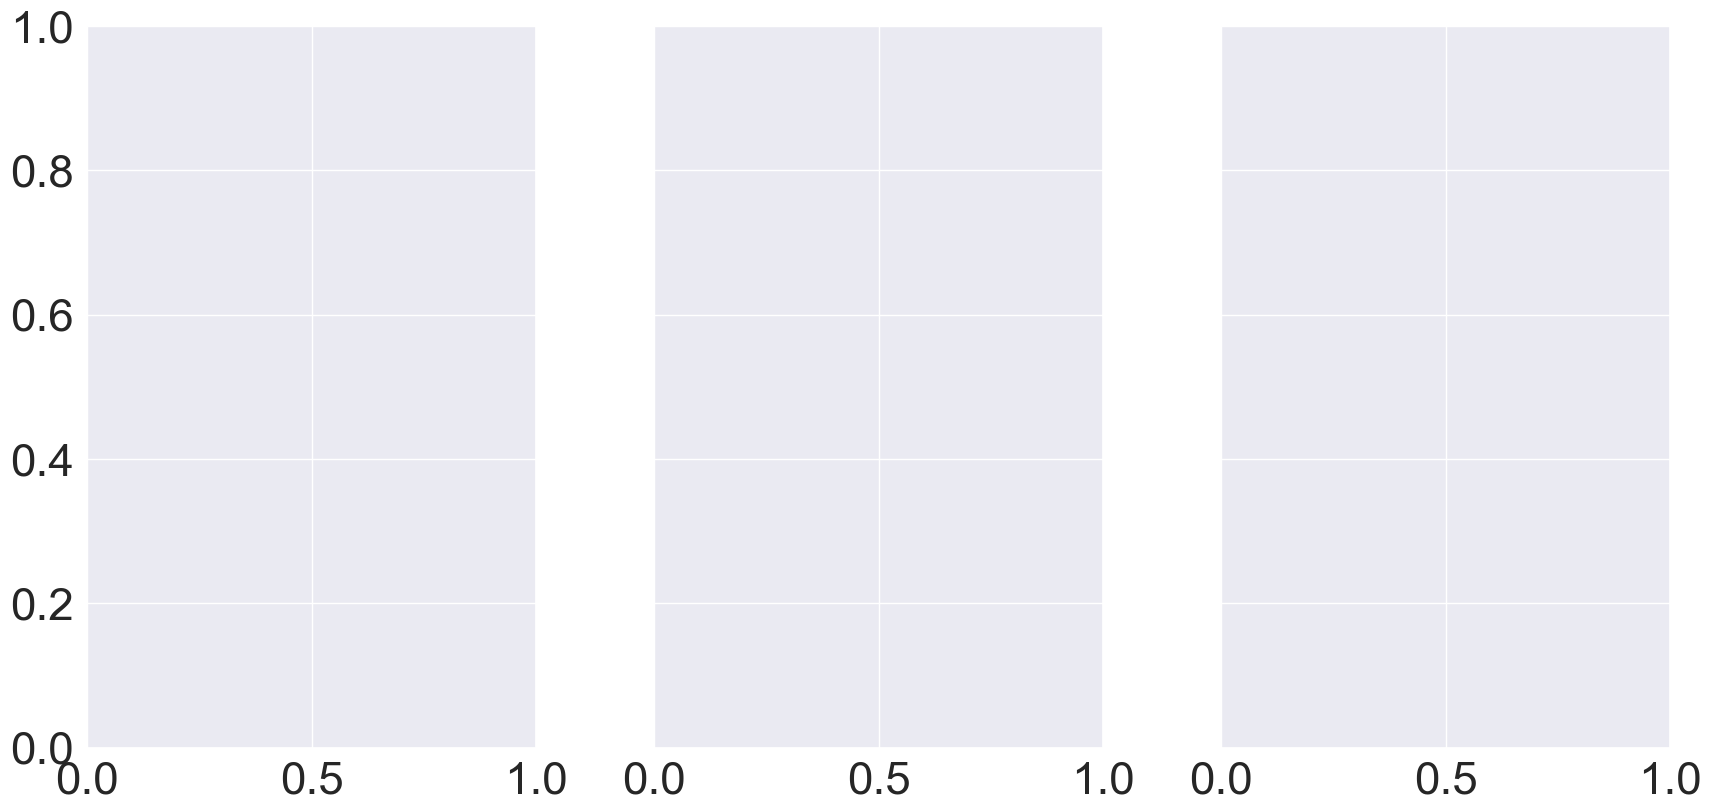

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X, y, cv_splits=15):
    """
    Evaluate a model using cross-validation and multiple metrics.
    
    Parameters:
    -----------
    model : sklearn estimator
        The machine learning model to evaluate
    X : pandas DataFrame
        Feature matrix
    y : pandas Series
        Target variable
    cv_splits : int
        Number of cross-validation splits
    
    Returns:
    --------
    dict
        Dictionary containing lists of scores for each metric
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    metrics = {
        'precision': [],
        'recall': [],
        'auc_pr': [],
        'f1_score': []
    }
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['auc_pr'].append(average_precision_score(y_test, y_pred_proba))
        metrics['f1_score'].append(f1_score(y_test, y_pred))
    
    return metrics

def run_friedman_analysis(X, y, models_dict, feature_cols, target_col):
    """
    Run Friedman test and post-hoc analysis on multiple models.
    
    Parameters:
    -----------
    X : pandas DataFrame
        Feature matrix
    y : pandas Series
        Target variable
    models_dict : dict
        Dictionary of model names and their instances
    feature_cols : list
        List of feature column names
    target_col : str
        Name of target variable
    """
    # Collect metrics for all models
    metrics_combined = {
        'precision': [],
        'recall': [],
        'auc_pr': [],
        'f1_score': []
    }
    
    # Evaluate each model
    for model_name, model in models_dict.items():
        scores = evaluate_model(model, X, y)
        for metric in scores:
            metrics_combined[metric].append(scores[metric])
    
    # Set up visualization
    sns.set(rc={'figure.figsize': (18, 9)}, font_scale=3)
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
    
    # Analyze and visualize results
    plot_count = 0
    for metric_name, metric_scores in metrics_combined.items():
        # Perform Friedman test
        stat, p_value = friedmanchisquare(*metric_scores)
        print(f'\nFriedman test for {metric_name.capitalize()}:')
        print(f'Statistic: {stat:.4f}, p-value: {p_value:.4f}')
        
        if p_value < 0.05 and plot_count < 3:
            # Create DataFrame for post-hoc analysis
            df_scores = pd.DataFrame(metric_scores).T
            df_scores.columns = models_dict.keys()
            
            # Calculate and display summary statistics
            metrics_summary = df_scores.agg(['mean', 'std']).round(4)
            print(f'\nMetrics Summary for {metric_name.capitalize()}:')
            print(metrics_summary)
            
            # Perform post-hoc analysis
            df_long = df_scores.melt(var_name='Model', value_name='Score')
            posthoc_results = sp.posthoc_conover(df_long, group_col='Model', 
                                               val_col='Score', p_adjust='holm')
            
            # Create heatmap
            heatmap_args = {
                'linewidths': 0.25,
                'linecolor': '0.5',
                'square': True,
                'cmap': 'viridis',
                'ax': axes[plot_count]
            }
            sp.sign_plot(posthoc_results, **heatmap_args)
            axes[plot_count].set_title(metric_name.replace("_", " ").upper())
            plot_count += 1
    
    plt.tight_layout()
    return fig, metrics_combined

# Define models
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=300, random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied']
y_var = 'clutch_performance'


# Example usage:
fig, metrics = run_friedman_analysis(df_players_merged[x_var], 
                                 df_players_merged[y_var], 
                                    models, 
                                    x_var, 
                                   y_var)
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied']
y_var = 'clutch_performance'

X = df_players_merged[x_var]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [48]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

scores = cross_validate(xgb_model, X, y, cv=5, scoring=scoring)

df = pd.DataFrame.from_dict(scores)

df.mean()

fit_time                  0.058107
score_time                0.012502
test_accuracy             0.813072
test_precision            0.176813
test_recall               0.063710
test_f1                   0.089164
test_average_precision    0.165184
dtype: float64

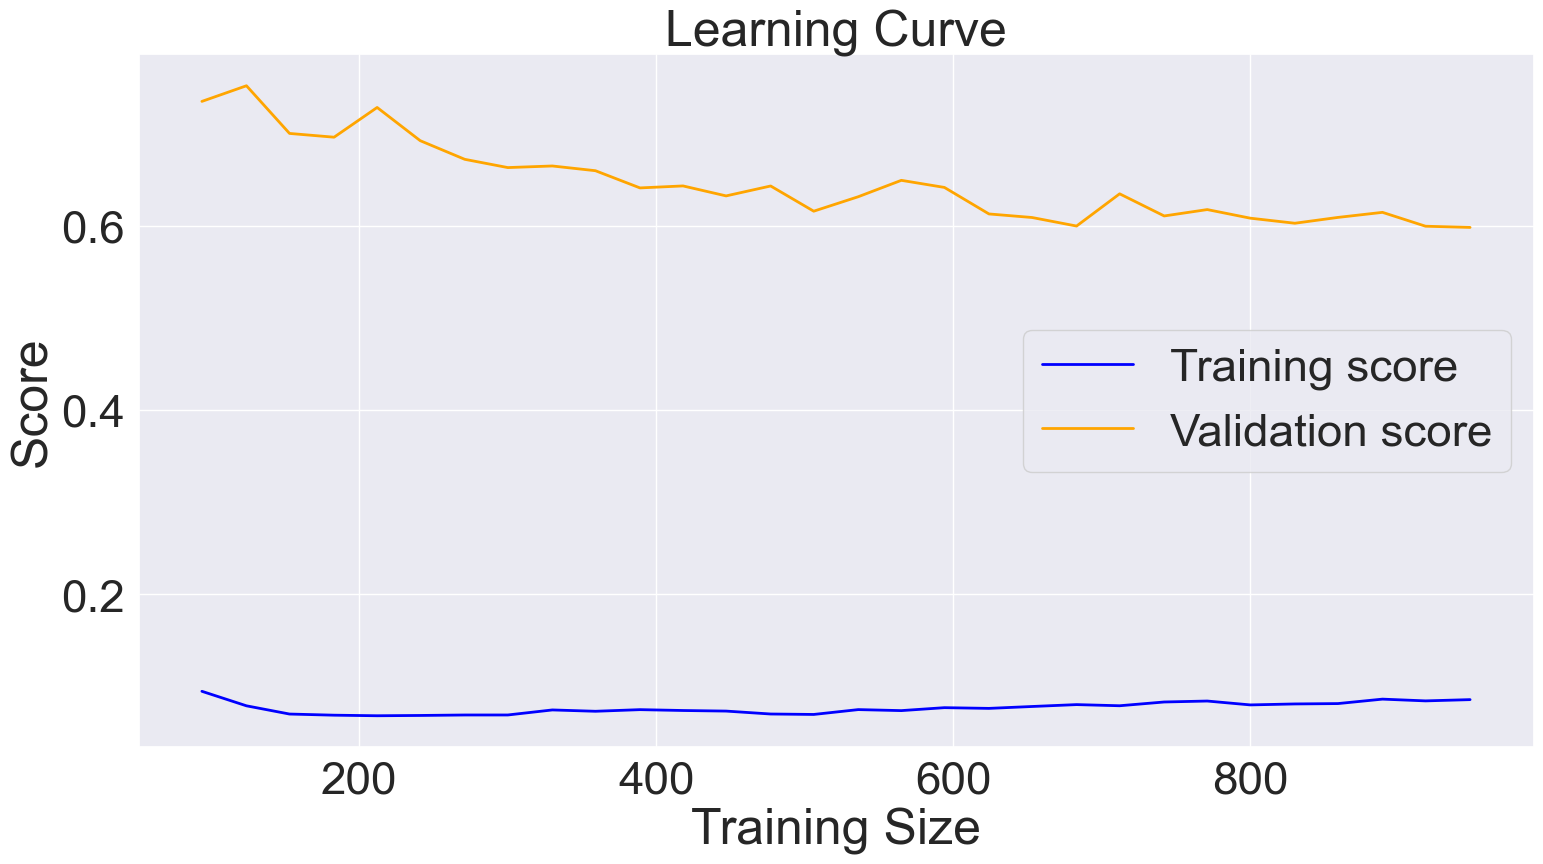

In [49]:
from sklearn.model_selection import learning_curve

cv = StratifiedKFold(n_splits=10)

train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y,
    train_sizes=np.linspace(0.1, 1, 30), 
    cv=cv, 
    scoring='neg_log_loss',  
    n_jobs=-1  
)

train_scores_mean = -np.mean(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
valid_scores_std = -np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_mean, label='Validation score', color='orange', linewidth=2)
plt.legend() 
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.show()

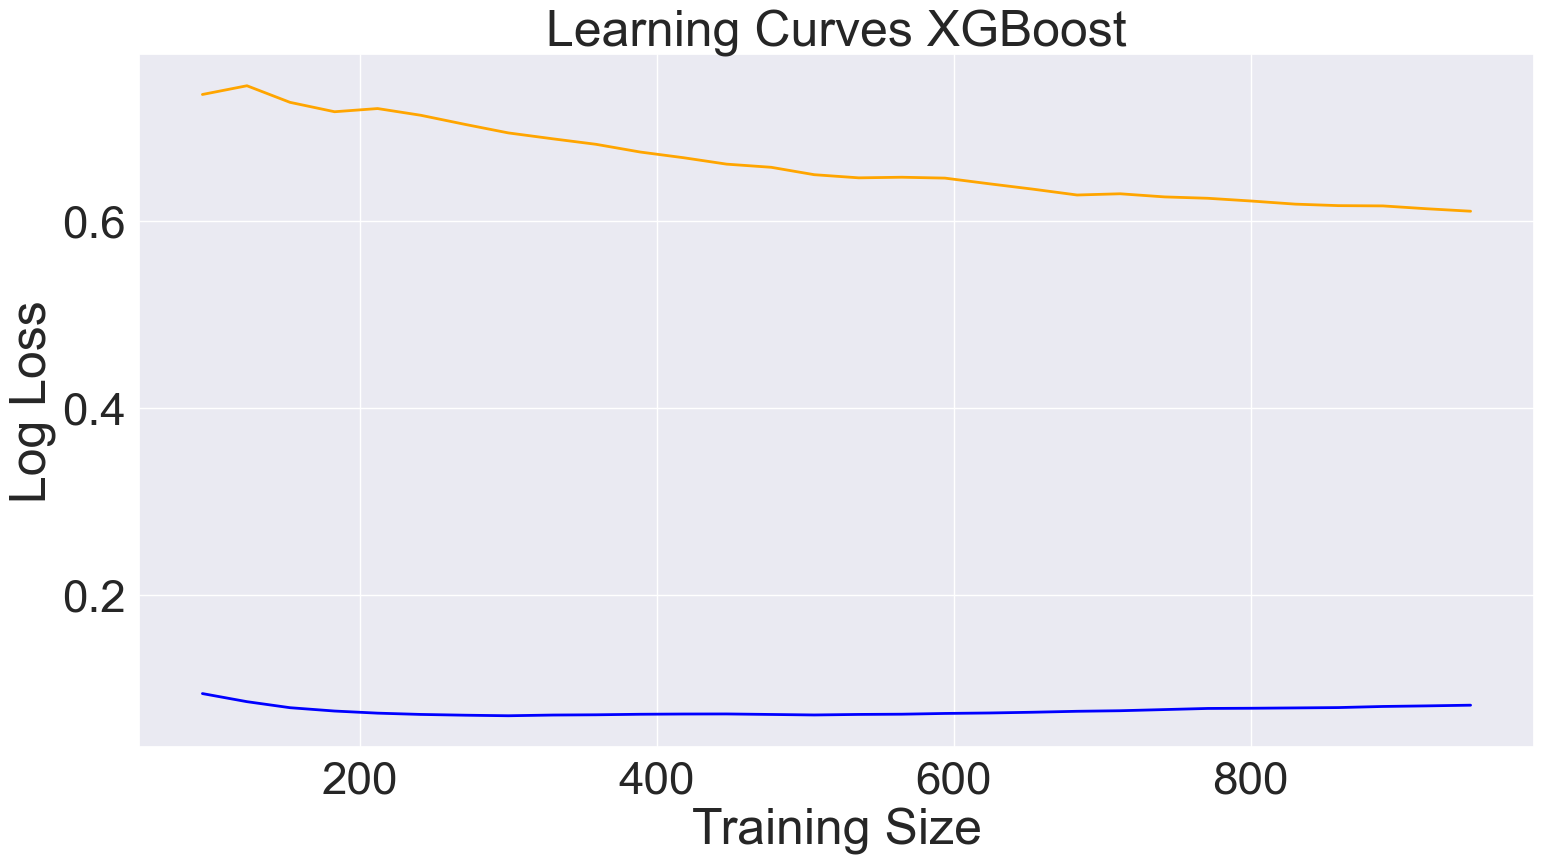

In [50]:
train_scores_smooth = pd.Series(train_scores_mean).ewm(span=10).mean()
valid_scores_smooth = pd.Series(valid_scores_mean).ewm(span=10).mean()

plt.plot(train_sizes, train_scores_smooth, label='Training score', color='blue', linewidth=2)
plt.plot(train_sizes, valid_scores_smooth, label='Cross-validation score', color='orange', linewidth=2)

plt.xlabel('Training Size')
plt.ylabel('Log Loss')
plt.title('Learning Curves XGBoost')
plt.show()

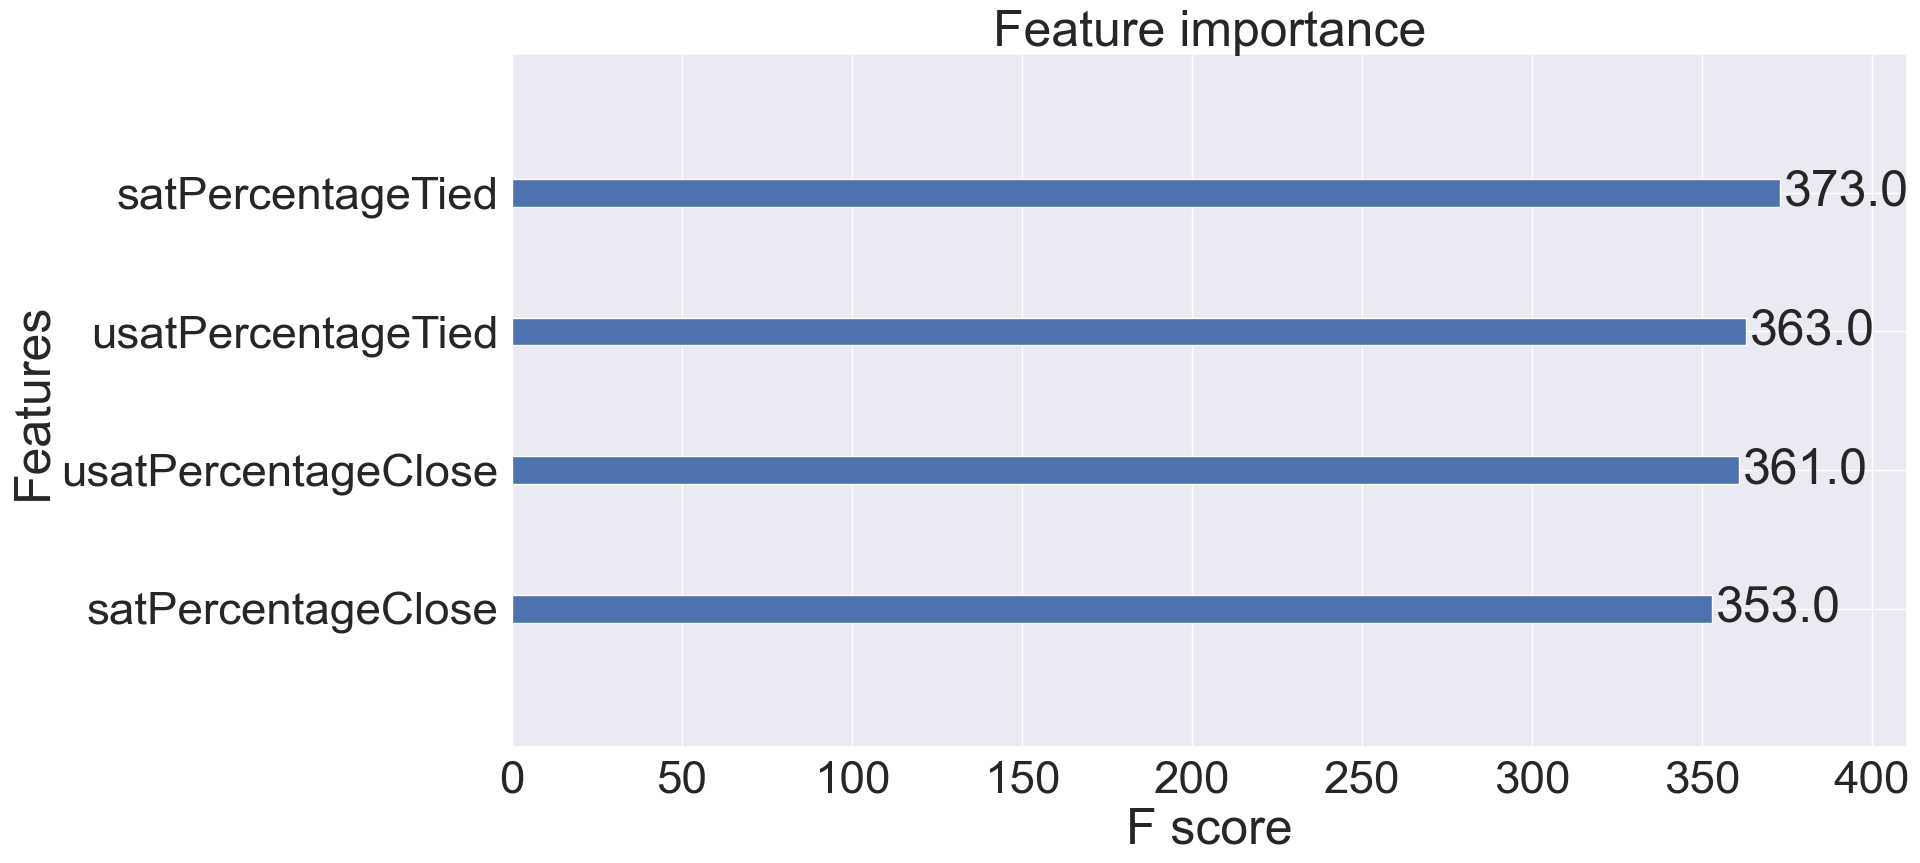

In [51]:
plot_importance(xgb_model)
plt.show()

In [52]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied', 'satPercentageClose']
y_var = 'clutch_performance'

X_adjusted = df_players_merged[x_var_adjusted]
y = df_players_merged[y_var]

train_x, test_x, train_y, test_y = train_test_split(X_adjusted, y, test_size=0.2, random_state=50)

xgb_model_adjusted = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model_adjusted.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [53]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math

scale_pos_weight = math.sqrt((df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum())

param_grid = {
    'max_depth': [1,3,5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8] 
}

fit_params = {
'early_stopping_rounds': 15,
}


[0]	validation_0-logloss:0.48893	validation_1-logloss:0.46522
[1]	validation_0-logloss:0.48695	validation_1-logloss:0.46547
[2]	validation_0-logloss:0.48248	validation_1-logloss:0.46122
[3]	validation_0-logloss:0.48270	validation_1-logloss:0.46040
[4]	validation_0-logloss:0.48042	validation_1-logloss:0.45700
[5]	validation_0-logloss:0.48071	validation_1-logloss:0.45824
[6]	validation_0-logloss:0.48097	validation_1-logloss:0.45681
[7]	validation_0-logloss:0.48126	validation_1-logloss:0.45692
[8]	validation_0-logloss:0.47826	validation_1-logloss:0.45274
[9]	validation_0-logloss:0.47435	validation_1-logloss:0.44761
[10]	validation_0-logloss:0.47166	validation_1-logloss:0.44611
[11]	validation_0-logloss:0.47237	validation_1-logloss:0.44891
[12]	validation_0-logloss:0.47030	validation_1-logloss:0.44681
[13]	validation_0-logloss:0.46861	validation_1-logloss:0.44553
[14]	validation_0-logloss:0.46829	validation_1-logloss:0.44524
[15]	validation_0-logloss:0.46767	validation_1-logloss:0.44495
[1

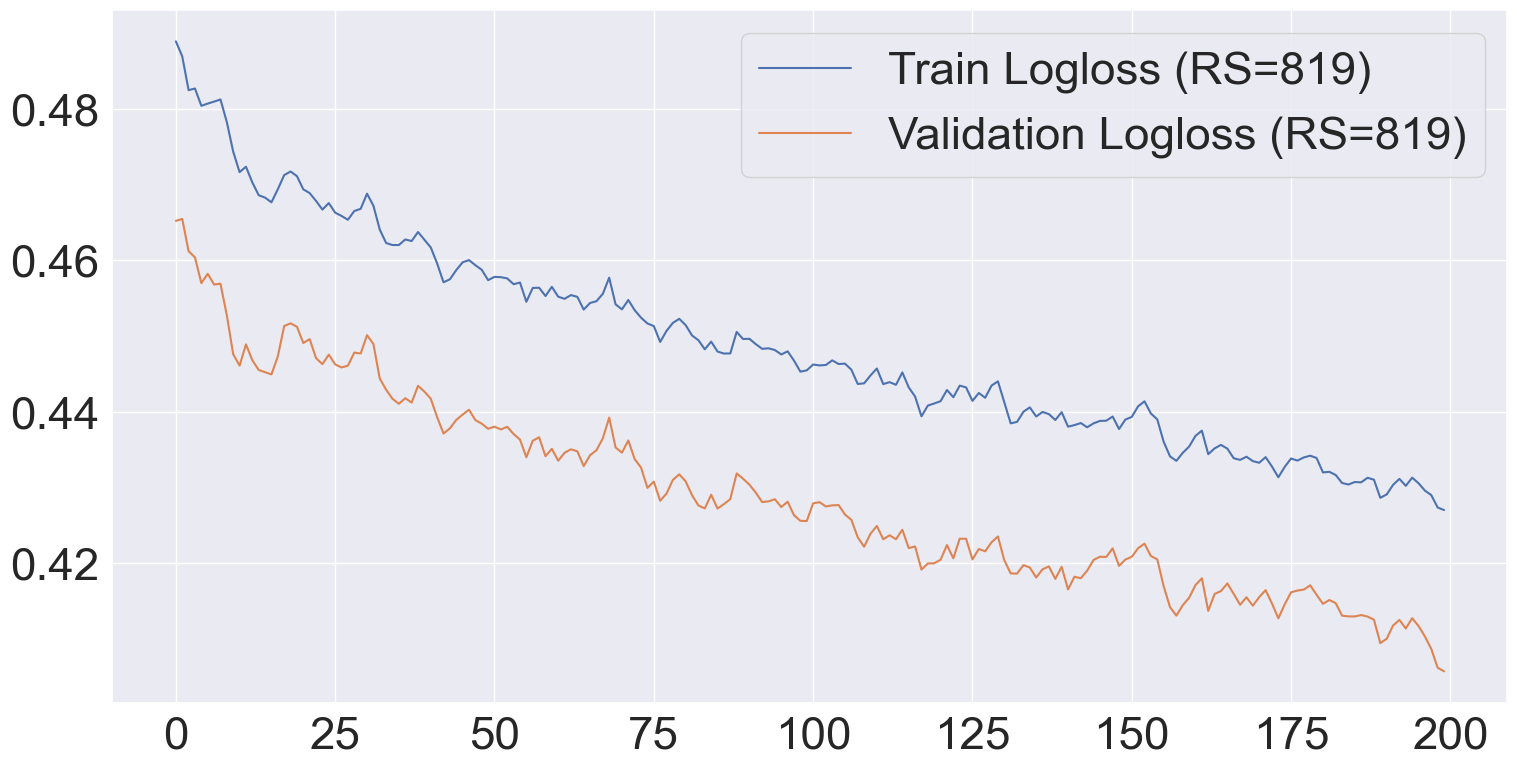

[0]	validation_0-logloss:0.49158	validation_1-logloss:0.46921
[1]	validation_0-logloss:0.49138	validation_1-logloss:0.46853
[2]	validation_0-logloss:0.48974	validation_1-logloss:0.46636
[3]	validation_0-logloss:0.48989	validation_1-logloss:0.46684
[4]	validation_0-logloss:0.48750	validation_1-logloss:0.46376
[5]	validation_0-logloss:0.48714	validation_1-logloss:0.46359
[6]	validation_0-logloss:0.48592	validation_1-logloss:0.46258
[7]	validation_0-logloss:0.48655	validation_1-logloss:0.46371
[8]	validation_0-logloss:0.48670	validation_1-logloss:0.46394
[9]	validation_0-logloss:0.48463	validation_1-logloss:0.46158
[10]	validation_0-logloss:0.48422	validation_1-logloss:0.46038
[11]	validation_0-logloss:0.48224	validation_1-logloss:0.45832
[12]	validation_0-logloss:0.47998	validation_1-logloss:0.45594
[13]	validation_0-logloss:0.47865	validation_1-logloss:0.45375
[14]	validation_0-logloss:0.47813	validation_1-logloss:0.45271
[15]	validation_0-logloss:0.47764	validation_1-logloss:0.45202
[1

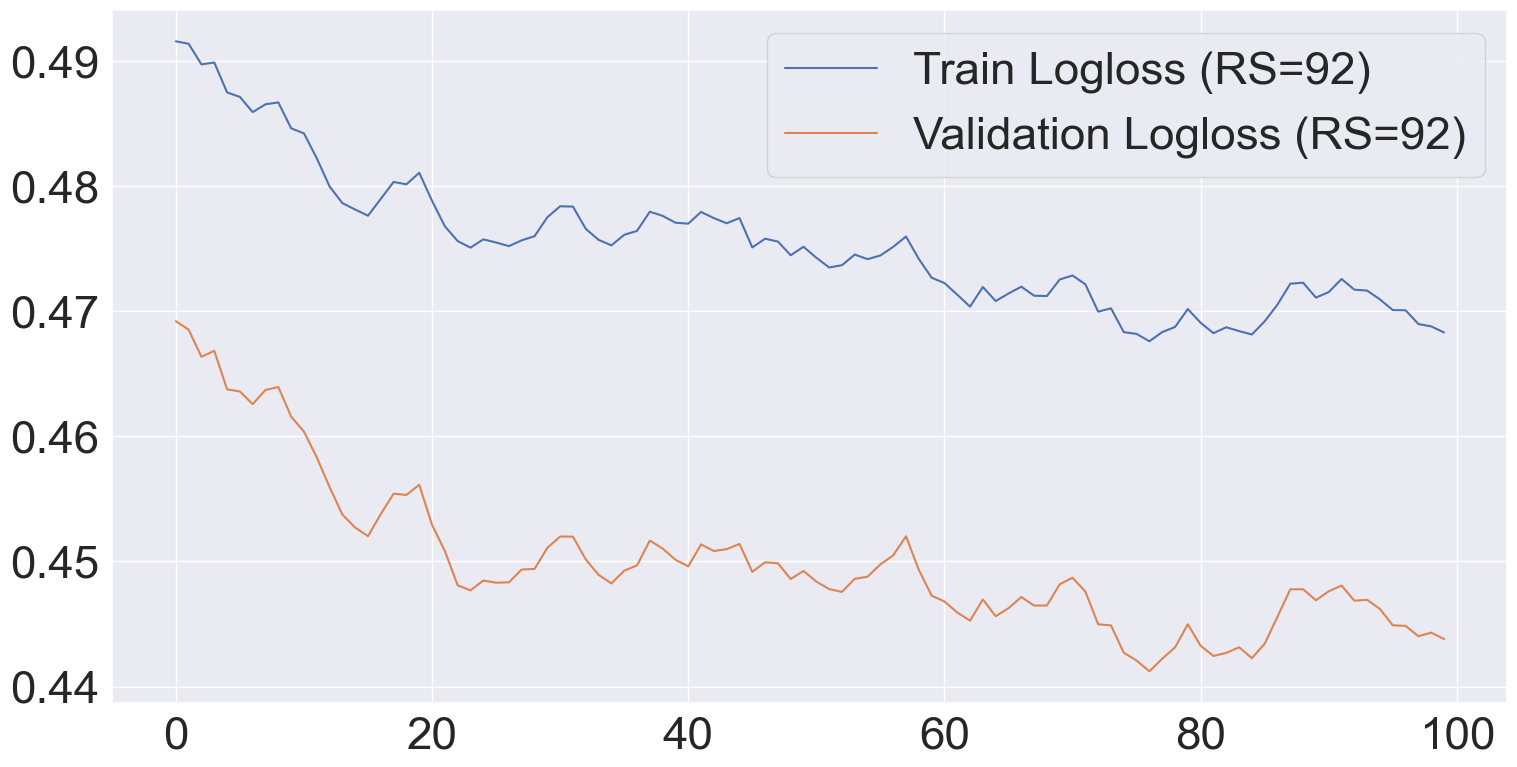

Average Accuracy: 0.8815165876777251
Average Precision: 0.8333333333333333
Average Recall: 0.12962962962962962
Average F1 Score: 0.20238095238095238
Averaged Hyperparameters:
colsample_bytree      0.400000
learning_rate         0.200000
max_depth             1.000000
min_child_weight      3.000000
n_estimators        150.000000
reg_alpha             1.000000
reg_lambda            0.750000
scale_pos_weight      2.381362
subsample             0.750000
dtype: float64


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

for _ in range(2):

    rs = np.random.randint(1, 1000)
    
    bayes_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter= 20, n_jobs=-1, random_state = rs, fit_params = fit_params)
    evalset = [(train_x, train_y), (test_x, test_y)]
    bayes_search.fit(X_adjusted, y, eval_set=evalset)

    xgb_best_model = bayes_search.best_estimator_
    results = xgb_best_model.evals_result()

    pyplot.plot(results['validation_0']['logloss'], label=f'Train Logloss (RS={rs})')
    pyplot.plot(results['validation_1']['logloss'], label=f'Validation Logloss (RS={rs})')

    pyplot.legend()
    pyplot.show()

    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)[:, 1]

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(bayes_search.best_params_)


print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [121]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(
    xgb_model_adjusted, X_adjusted, y, random_state=0
)


In [122]:
pvalue

0.009900990099009901

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

xgb_best_model = bayes_search.best_estimator_

y_true = test_y 

y_pred = xgb_best_model.predict(test_x[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_x[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))


Accuracy: 0.99
Precision: 0.93
Recall: 1.0
F1 Score: 0.96
AUC PR: 1.0


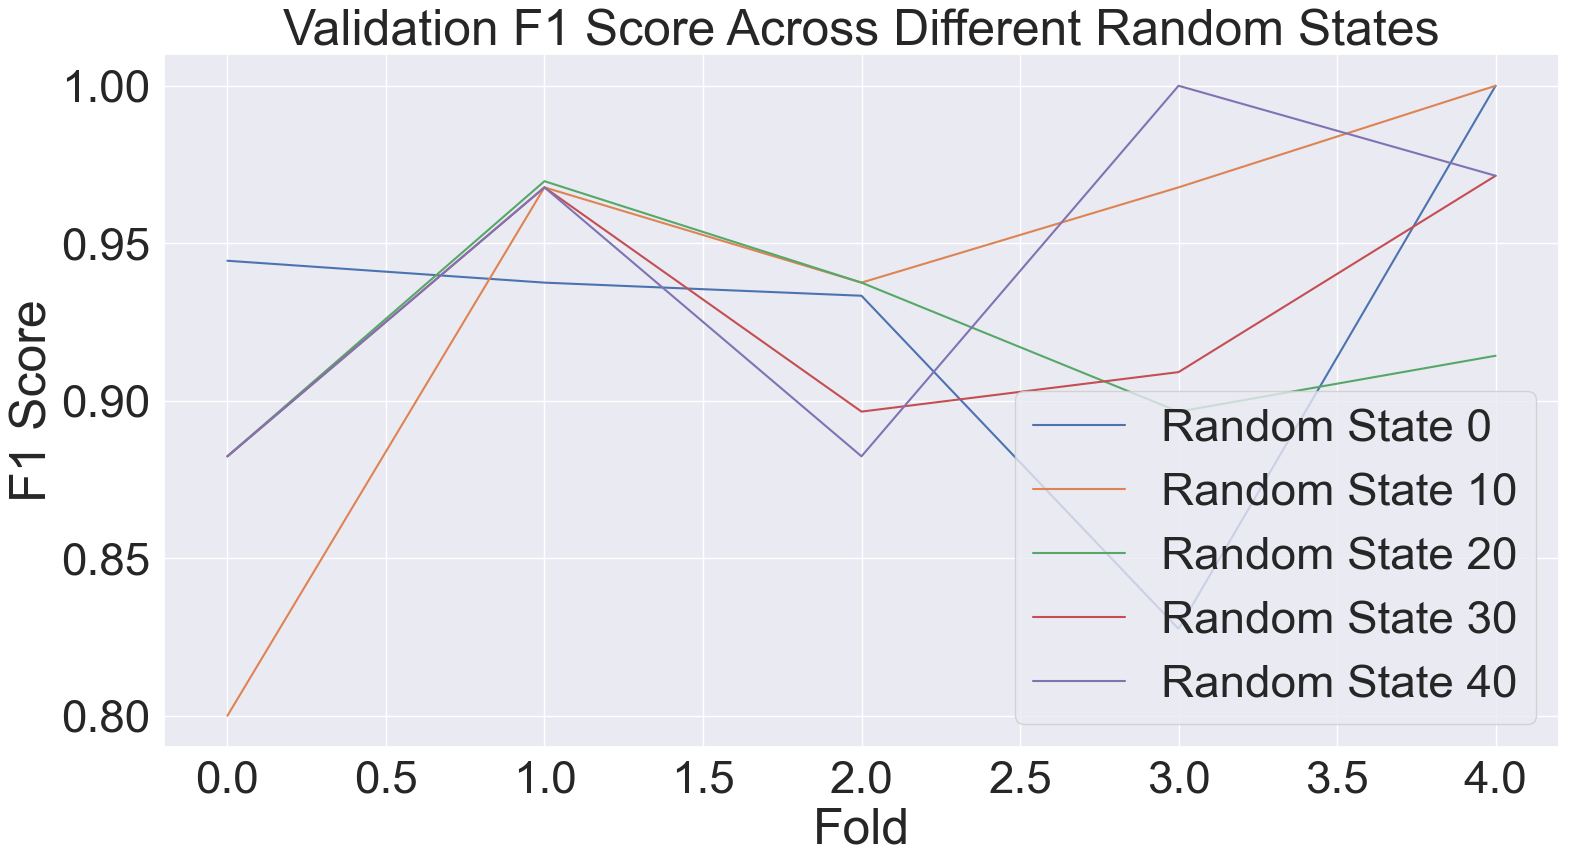

In [69]:
import matplotlib.pyplot as plt

random_states = [0, 10, 20, 30, 40]
for rs in random_states:
    train_scores = []
    val_scores = []
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)
    for train_idx, val_idx in cv.split(X, y):
        train_x, val_x = X.iloc[train_idx], X.iloc[val_idx]
        train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
        model.fit(train_x, train_y)
        
        train_pred = model.predict(train_x)
        val_pred = model.predict(val_x)
        
        train_scores.append(f1_score(train_y, train_pred))
        val_scores.append(f1_score(val_y, val_pred))

    plt.plot(val_scores, label=f'Random State {rs}')
    
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Across Different Random States')
plt.legend()
plt.show()


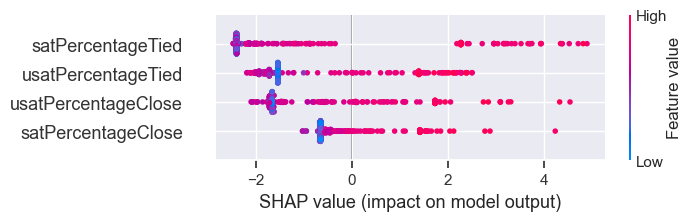

In [67]:
import shap

explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(train_xgb[x_var_adjusted])

shap.summary_plot(shap_values, train_xgb[x_var_adjusted])

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], train_xgb[x_var_adjusted].iloc[0])

NameError: name 'shap' is not defined

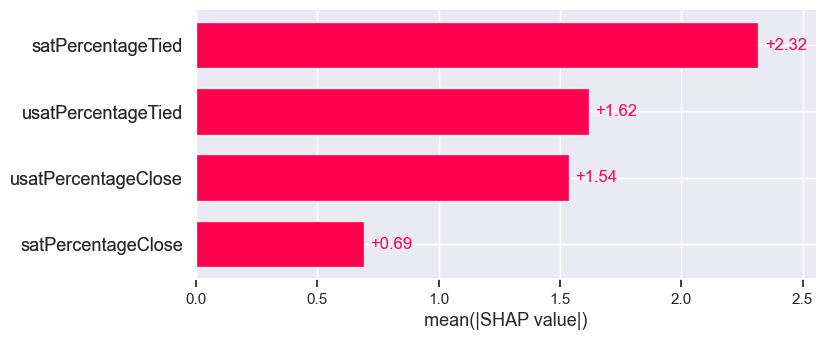

In [73]:
shap.plots.bar(shap_values)

In [102]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

train_xgb, test_xgb = train_test_split(random_sample, test_size=0.2, random_state=42)

evalset = [(train_xgb[x_var_adjusted], train_xgb[y_var]), (test_xgb[x_var_adjusted], test_xgb[y_var])]

xgb_best_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var], eval_set=evalset, verbose=True)

y_pred_final = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob_final = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]

[0]	validation_0-logloss:0.56224	validation_1-logloss:0.56961
[1]	validation_0-logloss:0.50006	validation_1-logloss:0.50637
[2]	validation_0-logloss:0.44693	validation_1-logloss:0.45241
[3]	validation_0-logloss:0.40412	validation_1-logloss:0.41778
[4]	validation_0-logloss:0.36397	validation_1-logloss:0.37638
[5]	validation_0-logloss:0.32892	validation_1-logloss:0.34022
[6]	validation_0-logloss:0.29815	validation_1-logloss:0.30847
[7]	validation_0-logloss:0.27102	validation_1-logloss:0.28047
[8]	validation_0-logloss:0.24892	validation_1-logloss:0.26310
[9]	validation_0-logloss:0.22739	validation_1-logloss:0.24049
[10]	validation_0-logloss:0.20823	validation_1-logloss:0.22035
[11]	validation_0-logloss:0.19113	validation_1-logloss:0.20236
[12]	validation_0-logloss:0.17583	validation_1-logloss:0.18625
[13]	validation_0-logloss:0.16210	validation_1-logloss:0.17179
[14]	validation_0-logloss:0.14977	validation_1-logloss:0.15879
[15]	validation_0-logloss:0.13868	validation_1-logloss:0.14708
[1

In [103]:
y_true = test_xgb[y_var]
y_pred = xgb_best_model.predict(test_xgb[x_var_adjusted])
y_pred_prob = xgb_best_model.predict_proba(test_xgb[x_var_adjusted])[:, 1]  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_pr = average_precision_score(y_true, y_pred_prob)

print("Accuracy:", round(accuracy,2))
print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
print("F1 Score:", round(f1,2))
print("AUC PR:", round(auc_pr,2))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


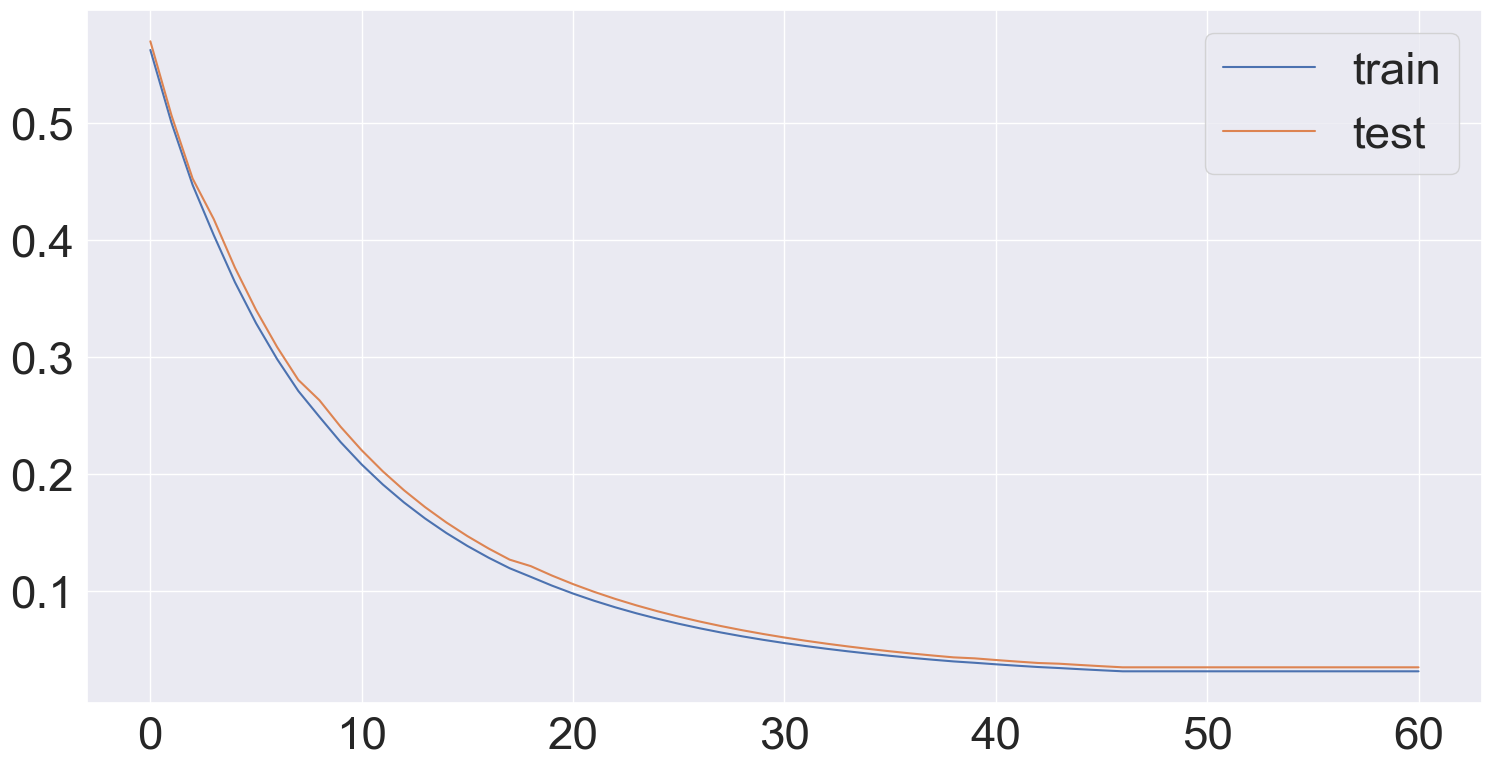

In [104]:
results = xgb_best_model.evals_result()

pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
pyplot.legend()
pyplot.show()

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

# Step 1: Use the best model to make predictions on the test set
y_true = df_test['clutch_performance']  # True labels from the test set
y_pred = xgb_best_model.predict(df_test[x_var_adjusted])  # Make predictions

# Step 2: Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_pr = average_precision_score(y_true, xgb_best_model.predict_proba(df_test[x_var_adjusted])[:, 1])  # AUC-PR

# Step 3: Print the results
print("Test Set Metrics:")
print("Accuracy:", round(accuracy, 2))
print("Precision:", round(precision, 2))
print("Recall:", round(recall, 2))
print("F1 Score:", round(f1, 2))
print("AUC PR:", round(auc_pr, 2))

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC PR: 1.0


In [33]:
xgb_model.fit(train_xgb[x_var_adjusted], train_xgb[y_var])

y_train_pred = xgb_model.predict(train_xgb[x_var_adjusted])

y_test_pred = xgb_model.predict(test_xgb[x_var_adjusted])

train_accuracy = accuracy_score(train_xgb[y_var], y_train_pred)
train_precision = precision_score(train_xgb[y_var], y_train_pred)
train_recall = recall_score(train_xgb[y_var], y_train_pred)
train_f1 = f1_score(train_xgb[y_var], y_train_pred)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.2f}, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1 Score: {train_f1:.2f}")


Training Set Metrics:
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1 Score: 1.00


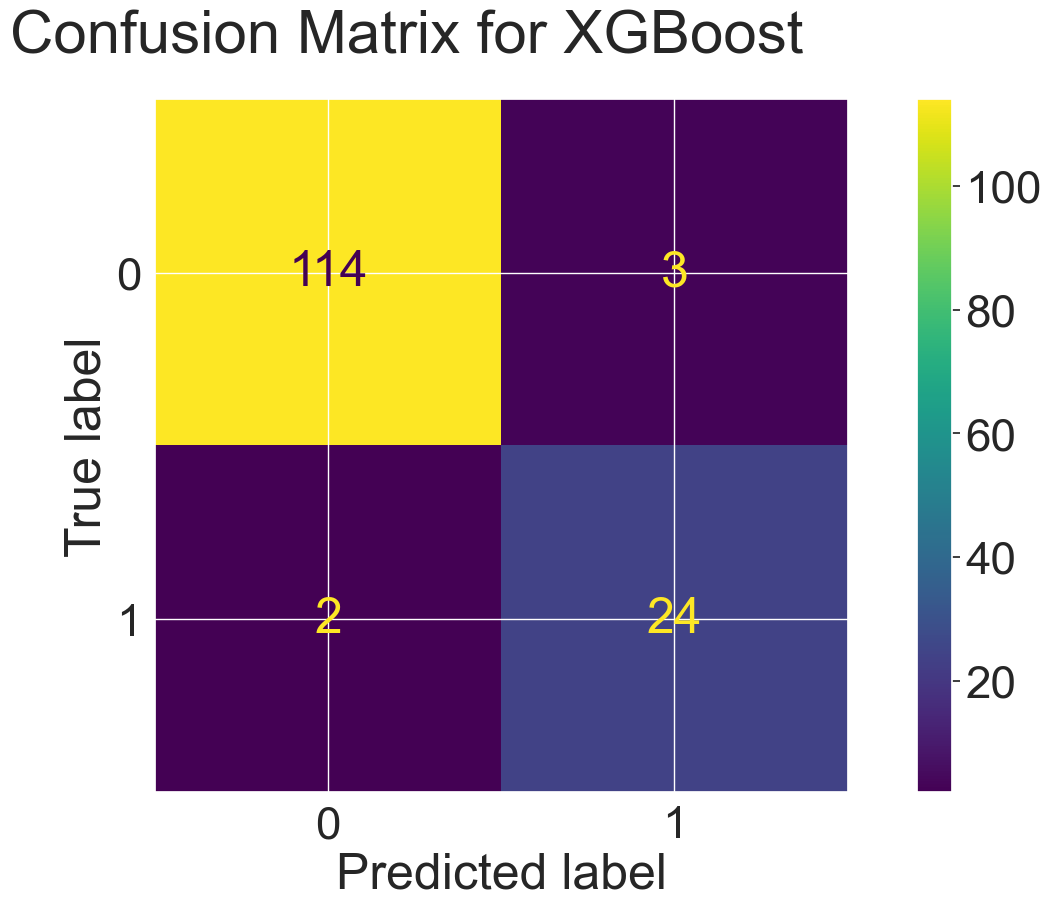

In [160]:
conf_matrix = confusion_matrix(y_pred_xgb, y_true_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [156]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(train[x_var], train[y_var].values.ravel())

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [scale_pos_weight],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],
    'reg_lambda':[0.1, 0.5, 1.0]
    
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, cv = 5, n_jobs = -1,n_iter=100)

start_time = time.time()
random_search.fit(train_xgb[x_var_adjusted], train_xgb[y_var])
xgb_duration = time.time() - start_time

print("Best Parameters:", random_search.best_params_)
print ("Time: ", xgb_duration)

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


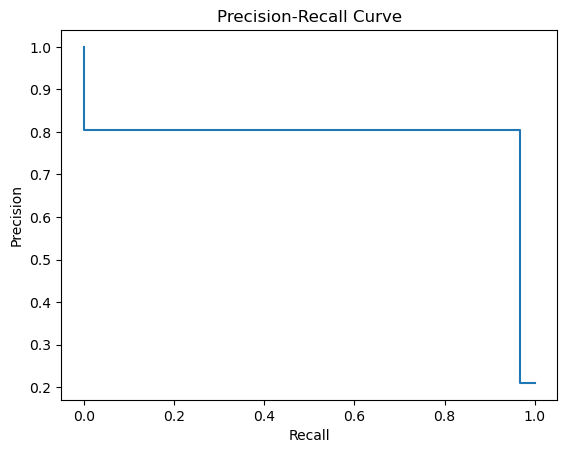

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

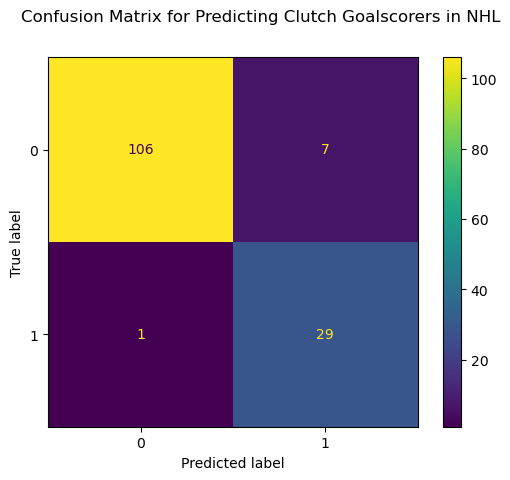

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
